<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [18]:
URL = 'https://www.indeed.co.uk/jobs?q=title%3Adata%2Bscientist&l=London&radius=100&start=50'

In [6]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pickle
import requests
from tqdm import tqdm
import re
import scipy.stats as stats
from time import sleep
from random import randint

import seaborn as sns
#import matpllib.pyplot as plt
sns.set(font_scale = 2)


In [20]:
r = requests.get(URL)

In [21]:
soup = BeautifulSoup(r.text, 'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

In [159]:
positions = ['Data Scientist', 'Data Analyst', 'Business Inteligence Analyst', 'Data Specialist', 'Data Architect',
             'Machine Learning','BI Analyst, Data Engineer', 'Data Modeler', 'Data Analysis', 'Analytics Engeeering',
            'Artificial Inteligence', 'AI', 'Deep Learning', 'BI']

In [23]:
locationUK = ['United Kingdom']

In [198]:
#For the UK
salary = []
jobTitle = []
location = []
company = []
radius = 100

for location in tqdm(locationUK):
    for position in positions:
        #lastpage = (int(len(jobTitle)/15)+1)*10
        for page in tqdm (range(0,700, 50)):
            sleep(randint(5,10))
            #URL = 'https://www.indeed.co.uk/jobs?as_and=&as_phr=%22{}%22&as_any=&as_not=&as_ttl=%22{}%22&as_cmp=&jt=all&st=&salary=&radius=25&l={}&fromage=any&limit={}&sort=&psf=advsrch&from=advancedsearch'
            #URL = 'https://www.indeed.co.uk/jobs?q={}&l={}&radius=100&limit=50&start={}'
            URL = 'https://www.indeed.co.uk/jobs?q={}&l={}&radius=100&limit=50&start={}'                    
            r = requests.get(URL.format(position, locationUK, page))
            soup = BeautifulSoup(r.text, 'html.parser')
            for job in soup.find_all('div', attrs = {'data-tn-component':'organicJob'}):
                try:
                    jobTitle.append(job.find('a', attrs = {'data-tn-element':'jobTitle'}).text.strip('\n'))
                except:
                    jobTitle.append(np.nan)
                try:
                    salary.append(job.find('span', attrs = {'class':'salaryText'}).text.strip('\n'))
                except:
                    salary.append(np.nan)
                try:
                    company.append(job.find('span', attrs = {'class': 'company'}).text.strip('\n'))
                except:
                    company.append(np.nan)
                    print('location:' , location, 'position:' , position, 'company:' ,company)
                    
jobsUK = pd. DataFrame({'company':company,
                       'jobTitle': jobTitle,
                       'salary': salary,
                       'location': location})
jobsUK








  0%|          | 0/1 [00:00<?, ?it/s]





  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:07<01:43,  7.99s/it]





 14%|█▍        | 2/14 [00:19<01:48,  9.06s/it]





 21%|██▏       | 3/14 [00:28<01:37,  8.88s/it]





 29%|██▊       | 4/14 [00:34<01:21,  8.16s/it]





 36%|███▌      | 5/14 [00:42<01:12,  8.00s/it]





 43%|████▎     | 6/14 [00:48<01:01,  7.67s/it]





 50%|█████     | 7/14 [00:59<00:59,  8.51s/it]





 57%|█████▋    | 8/14 [01:07<00:49,  8.22s/it]





 64%|██████▍   | 9/14 [01:15<00:41,  8.38s/it]





 71%|███████▏  | 10/14 [01:26<00:36,  9.00s/it]





 79%|███████▊  | 11/14 [01:36<00:28,  9.49s/it]





 86%|████████▌ | 12/14 [01:45<00:18,  9.17s/it]





 93%|█████████▎| 13/14 [01:56<00:09,  9.64s/it]





100%|██████████| 14/14 [02:05<00:00,  8.97s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:06<01:25,  6.59s/it]





 14%|█▍        | 2/14 [00:14<01:22,  6.88s/it]





 21%|██▏       | 3/14 [00:

location: United Kingdom position: Data Specialist company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsolutions', '







100%|██████████| 14/14 [02:15<00:00,  9.69s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:08<01:46,  8.21s/it]





 14%|█▍        | 2/14 [00:16<01:38,  8.23s/it]





 21%|██▏       | 3/14 [00:24<01:30,  8.20s/it]





 29%|██▊       | 4/14 [00:33<01:25,  8.52s/it]





 36%|███▌      | 5/14 [00:43<01:19,  8.79s/it]





 43%|████▎     | 6/14 [00:51<01:08,  8.59s/it]





 50%|█████     | 7/14 [01:02<01:05,  9.33s/it]





 57%|█████▋    | 8/14 [01:11<00:55,  9.24s/it]





 64%|██████▍   | 9/14 [01:22<00:49,  9.83s/it]





 71%|███████▏  | 10/14 [01:32<00:39,  9.92s/it]





 79%|███████▊  | 11/14 [01:41<00:28,  9.41s/it]





 86%|████████▌ | 12/14 [01:52<00:19,  9.92s/it]





 93%|█████████▎| 13/14 [01:59<00:09,  9.07s/it]





100%|██████████| 14/14 [02:08<00:00,  9.17s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:07<01:33,  7.19s/it]





 14%|█▍        | 2/14 [00:13<01:23,  6.99s/it]





 21%|██▏      

location: United Kingdom position: BI Analyst, Data Engineer company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsol







 36%|███▌      | 5/14 [00:48<01:30, 10.03s/it]





 43%|████▎     | 6/14 [00:55<01:13,  9.16s/it]





 50%|█████     | 7/14 [01:05<01:07,  9.59s/it]

location: United Kingdom position: BI Analyst, Data Engineer company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsol







 57%|█████▋    | 8/14 [01:15<00:58,  9.68s/it]

location: United Kingdom position: BI Analyst, Data Engineer company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsol







 64%|██████▍   | 9/14 [01:27<00:52, 10.42s/it]





 71%|███████▏  | 10/14 [01:34<00:37,  9.31s/it]





 79%|███████▊  | 11/14 [01:42<00:26,  8.88s/it]





 86%|████████▌ | 12/14 [01:52<00:18,  9.15s/it]

location: United Kingdom position: BI Analyst, Data Engineer company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsol







 93%|█████████▎| 13/14 [01:58<00:08,  8.36s/it]





100%|██████████| 14/14 [02:05<00:00,  8.97s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:11<02:29, 11.50s/it]





 14%|█▍        | 2/14 [00:20<02:09, 10.80s/it]





 21%|██▏       | 3/14 [00:31<01:57, 10.68s/it]





 29%|██▊       | 4/14 [00:39<01:39,  9.94s/it]





 36%|███▌      | 5/14 [00:49<01:30, 10.02s/it]





 43%|████▎     | 6/14 [00:57<01:15,  9.50s/it]





 50%|█████     | 7/14 [01:07<01:07,  9.71s/it]





 57%|█████▋    | 8/14 [01:17<00:57,  9.64s/it]





 64%|██████▍   | 9/14 [01:24<00:43,  8.78s/it]





 71%|███████▏  | 10/14 [01:30<00:32,  8.10s/it]





 79%|███████▊  | 11/14 [01:39<00:24,  8.26s/it]





 86%|████████▌ | 12/14 [01:48<00:17,  8.55s/it]





 93%|█████████▎| 13/14 [01:57<00:08,  8.77s/it]





100%|██████████| 14/14 [02:08<00:00,  9.15s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:10<02:21, 10.86s/it]





 14%|█▍      

location: United Kingdom position: Data Analysis company: ['Utilita', 'Lloyds Banking Group', 'AXA UK', 'SoulTek', 'TikTok', 'West London NHS Trust', 'University of Oxford', 'Doncaster and Bassetlaw Teaching Hospitals NHS Fou...', 'Tessella', 'High Speed Two (HS2)', 'Experian', 'G-Research', 'Agilent Technologies, Inc.', 'Mettle', 'HSBC UK', 'Novafutur', 'Public Health England', 'Argus Media', 'Arm', 'Deliveroo', 'BAE Systems Applied Intelligence', 'UK Government - Office for National Statistics', 'Experian', 'SoulTek', 'Data Talent', 'Facebook', 'Refinitiv', 'KANTAR', 'Babcock', 'BT', 'University of Oxford', 'Procter & Gamble', 'University of Oxford', 'BNY Mellon', 'Opus Energy', 'Wellcome Trust Sanger Institute', 'Tripledot Studios', 'Lubrizol Corporation', 'Simply Business', 'Jacobs', 'Amazon Digital UK Limited', 'Admiral', 'UCAS', 'Current Health Careers', 'Argus Media', 'Deliveroo', 'Facebook', 'Tetra Pak', 'ASDA', 'causaLens', 'Apple', 'Echobox', 'PwC', 'managementsolutions', 'Mo







100%|██████████| 14/14 [02:06<00:00,  9.05s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:09<02:09,  9.95s/it]





 14%|█▍        | 2/14 [00:16<01:48,  9.04s/it]





 21%|██▏       | 3/14 [00:23<01:32,  8.44s/it]





 29%|██▊       | 4/14 [00:30<01:20,  8.00s/it]





 36%|███▌      | 5/14 [00:37<01:09,  7.72s/it]





 43%|████▎     | 6/14 [00:45<01:02,  7.82s/it]





 50%|█████     | 7/14 [00:56<00:59,  8.54s/it]





 57%|█████▋    | 8/14 [01:07<00:55,  9.24s/it]





 64%|██████▍   | 9/14 [01:18<00:48,  9.75s/it]





 71%|███████▏  | 10/14 [01:27<00:39,  9.81s/it]





 79%|███████▊  | 11/14 [01:37<00:29,  9.85s/it]





 86%|████████▌ | 12/14 [01:44<00:17,  8.98s/it]





 93%|█████████▎| 13/14 [01:52<00:08,  8.69s/it]





100%|██████████| 14/14 [02:02<00:00,  8.73s/it]






  0%|          | 0/14 [00:00<?, ?it/s]





  7%|▋         | 1/14 [00:08<01:44,  8.05s/it]





 14%|█▍        | 2/14 [00:18<01:44,  8.67s/it]





 21%|██▏      

company  \
0                   Utilita   
1      Lloyds Banking Group   
2                    AXA UK   
3                   SoulTek   
4                    TikTok   
...                     ...   
6715  Norton Rose Fulbright   
6716            Mundipharma   
6717        Hastings Direct   
6718                  KSEYE   
6719           Paymentsense   

                                               jobTitle  \
0                                        Data Scientist   
1                                        Data Scientist   
2                                        Data Scientist   
3                            Data Scientist – Team Lead   
4     Graduate Machine Learning Engineer (Trust and ...   
...                                                 ...   
6715                        Change Manager (12 mth FTC)   
6716                       Corporate Accounting Manager   
6717                       Large & Complex Loss Handler   
6718                                  Marketing Manager   
6719                       Head of Commercial Analytics   

                        salary        location  
0               £28,863 a year  United Kingdom  
1     £43,029 - £47,810 a year  United Kingdom  
2                          NaN  United Kingdom  
3     £75,000 - £95,000 a year  United Kingdom  
4                          NaN  United Kingdom  
...                        ...             ...  
6715                       NaN  United Kingdom  
6716                       NaN  United Kingdom  
6717                       NaN  United Kingdom  
6718  £45,000 - £55,000 a year  United Kingdom  
6719                       NaN  United Kingdom  

[6720 rows x 4 columns]

In [207]:
#saving to a CSV file:
jobsUK.to_csv('jobsUK.csv')

In [214]:
jobsUK = pd.read_csv('./jobsUK.csv')
jobsUK.head()

Unnamed: 0  Unnamed: 0.1               company  \
0           0             0               Utilita   
1           1             1  Lloyds Banking Group   
2           2             2                AXA UK   
3           3             3               SoulTek   
4           4             4                TikTok   

                                            jobTitle  \
0                                     Data Scientist   
1                                     Data Scientist   
2                                     Data Scientist   
3                         Data Scientist – Team Lead   
4  Graduate Machine Learning Engineer (Trust and ...   

                     salary        location  
0            £28,863 a year  United Kingdom  
1  £43,029 - £47,810 a year  United Kingdom  
2                       NaN  United Kingdom  
3  £75,000 - £95,000 a year  United Kingdom  
4                       NaN  United Kingdom

In [231]:
jobsUK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720 entries, 0 to 6719
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   6714 non-null   object
 1   jobTitle  6720 non-null   object
 2   salary    2068 non-null   object
 3   location  6720 non-null   object
dtypes: object(4)
memory usage: 210.1+ KB


In [230]:
jobsUK.drop(columns = ['Unnamed: 0'], inplace=True)

In [232]:
jobsUK.isnull().sum().sort_values(ascending=False)

salary      4652
company        6
location       0
jobTitle       0
dtype: int64

In [236]:
jobsUK.isna().sum().sort_values(ascending=False)

salary      4652
company        6
location       0
jobTitle       0
dtype: int64

In [241]:
jobsUK.salary.value_counts

<bound method IndexOpsMixin.value_counts of 0                 £28,863 a year
1       £43,029 - £47,810 a year
2                            NaN
3       £75,000 - £95,000 a year
4                            NaN
                  ...           
6715                         NaN
6716                         NaN
6717                         NaN
6718    £45,000 - £55,000 a year
6719                         NaN
Name: salary, Length: 6720, dtype: object>

In [245]:
jobsUK.salary.unique()

array(['£28,863 a year', '£43,029 - £47,810 a year', nan,
       '£75,000 - £95,000 a year', '£43,712 - £49,325 a year',
       '£32,817 - £40,322 a year', '£38,890 - £44,503 a year',
       '£28,588 - £39,691 a year', '£36,027 a year',
       '£45,000 - £60,000 a year', '£50,000 - £60,000 a year',
       '£55,000 - £65,000 a year', '£26,156 - £31,333 a year',
       '£85,000 a year', '£49,000 - £80,000 a year', '£34,090 a year',
       '£30,000 - £40,000 a year', '£18,500 a year', '£21,500 a year',
       '£50,000 - £65,000 a year', '£50,000 - £90,000 a year',
       '£500 - £600 a day', '£28,996 a year', '£600 - £700 a day',
       '£65,000 - £70,000 a year', '£50,000 - £55,000 a year',
       '£55,000 - £70,000 a year', '£60,000 a year',
       '£85,000 - £90,000 a year', '£31,365 a year', '£50,000 a year',
       '£60,000 - £70,000 a year', '£30,000 - £45,000 a year',
       '£35,845 - £40,322 a year', '£34,804 - £40,322 a year',
       '£60,000 - £90,000 a year', '£34,189 - £38,46

In [249]:
jobsUK.dropna(inplace=True)
jobsUK

company                            jobTitle  \
0                    Utilita                      Data Scientist   
1       Lloyds Banking Group                      Data Scientist   
3                    SoulTek          Data Scientist – Team Lead   
5      West London NHS Trust                      Data Scientist   
6       University of Oxford  Postdoctoral Health Data Scientist   
...                      ...                                 ...   
6703            Intec Select          HEAD OF PRODUCT MANAGEMENT   
6704  Pertemps Network Group                     Data Visualiser   
6706             Voyage Care               Application Developer   
6710   The Co-operative Bank             Data Governance Analyst   
6718                   KSEYE                   Marketing Manager   

                        salary        location  
0               £28,863 a year  United Kingdom  
1     £43,029 - £47,810 a year  United Kingdom  
3     £75,000 - £95,000 a year  United Kingdom  
5     £43,712 - £49,325 a year  United Kingdom  
6     £32,817 - £40,322 a year  United Kingdom  
...                        ...             ...  
6703  £75,000 - £80,000 a year  United Kingdom  
6704  £30,000 - £37,000 a year  United Kingdom  
6706            £27,000 a year  United Kingdom  
6710  £34,000 - £43,000 a year  United Kingdom  
6718  £45,000 - £55,000 a year  United Kingdom  

[2068 rows x 4 columns]

In [250]:
jobsUK = jobsUK[jobsUK.salary.str.contains('year')]
jobsUK

company                            jobTitle  \
0                    Utilita                      Data Scientist   
1       Lloyds Banking Group                      Data Scientist   
3                    SoulTek          Data Scientist – Team Lead   
5      West London NHS Trust                      Data Scientist   
6       University of Oxford  Postdoctoral Health Data Scientist   
...                      ...                                 ...   
6703            Intec Select          HEAD OF PRODUCT MANAGEMENT   
6704  Pertemps Network Group                     Data Visualiser   
6706             Voyage Care               Application Developer   
6710   The Co-operative Bank             Data Governance Analyst   
6718                   KSEYE                   Marketing Manager   

                        salary        location  
0               £28,863 a year  United Kingdom  
1     £43,029 - £47,810 a year  United Kingdom  
3     £75,000 - £95,000 a year  United Kingdom  
5     £43,712 - £49,325 a year  United Kingdom  
6     £32,817 - £40,322 a year  United Kingdom  
...                        ...             ...  
6703  £75,000 - £80,000 a year  United Kingdom  
6704  £30,000 - £37,000 a year  United Kingdom  
6706            £27,000 a year  United Kingdom  
6710  £34,000 - £43,000 a year  United Kingdom  
6718  £45,000 - £55,000 a year  United Kingdom  

[1865 rows x 4 columns]

In [252]:
slrUK = jobsUK['salary'].str.split('a', expand=True)
slrUK[0] = slrUK[0].str.replace('£', '')
slrUK

0    1  2
0              28,863    ye  r
1     43,029 - 47,810    ye  r
3     75,000 - 95,000    ye  r
5     43,712 - 49,325    ye  r
6     32,817 - 40,322    ye  r
...                ...  ... ..
6703  75,000 - 80,000    ye  r
6704  30,000 - 37,000    ye  r
6706           27,000    ye  r
6710  34,000 - 43,000    ye  r
6718  45,000 - 55,000    ye  r

[1865 rows x 3 columns]

In [255]:
slrUK = slrUK[0].str.split('-', expand = True)
slrUK

0         1
0     28,863       None
1     43,029    47,810 
3     75,000    95,000 
5     43,712    49,325 
6     32,817    40,322 
...       ...       ...
6703  75,000    80,000 
6704  30,000    37,000 
6706  27,000       None
6710  34,000    43,000 
6718  45,000    55,000 

[1865 rows x 2 columns]

In [257]:
slrUK[0] = slrUK[0].str.replace(',', '')
slrUK[1] = slrUK[1].str.replace(',' , '')
slrUK

0        1
0     28863      None
1     43029    47810 
3     75000    95000 
5     43712    49325 
6     32817    40322 
...      ...      ...
6703  75000    80000 
6704  30000    37000 
6706  27000      None
6710  34000    43000 
6718  45000    55000 

[1865 rows x 2 columns]

In [258]:
slrUK[0] = slrUK[0].astype(float)
slrUK[1] = slrUK[1].astype(float)
slrUK['average salary'] = slrUK.mean(axis=1)
slrUK

0        1  average salary
0     28863.0      NaN         28863.0
1     43029.0  47810.0         45419.5
3     75000.0  95000.0         85000.0
5     43712.0  49325.0         46518.5
6     32817.0  40322.0         36569.5
...       ...      ...             ...
6703  75000.0  80000.0         77500.0
6704  30000.0  37000.0         33500.0
6706  27000.0      NaN         27000.0
6710  34000.0  43000.0         38500.0
6718  45000.0  55000.0         50000.0

[1865 rows x 3 columns]

In [283]:
#Converting into Euros
from forex_python.converter import CurrencyRates 
c = CurrencyRates()
currency = c.get_rate('GBP', 'EUR')  #convert GBP to EURO
print(currency)

1.1029979484


In [272]:
slrUK

0        1  average salary
0     28863.0      NaN         28863.0
1     43029.0  47810.0         45419.5
3     75000.0  95000.0         85000.0
5     43712.0  49325.0         46518.5
6     32817.0  40322.0         36569.5
...       ...      ...             ...
6703  75000.0  80000.0         77500.0
6704  30000.0  37000.0         33500.0
6706  27000.0      NaN         27000.0
6710  34000.0  43000.0         38500.0
6718  45000.0  55000.0         50000.0

[1865 rows x 3 columns]

In [286]:
#convert 'average salary' column into EUR
slrUK['converted to Euros'] = slrUK['average salary'] * currency 
slrUK

0        1  average salary  converted to Euros
0     28863.0      NaN         28863.0        31835.829785
1     43029.0  47810.0         45419.5        50097.615317
3     75000.0  95000.0         85000.0        93754.825614
5     43712.0  49325.0         46518.5        51309.810063
6     32817.0  40322.0         36569.5        40336.083474
...       ...      ...             ...                 ...
6703  75000.0  80000.0         77500.0        85482.341001
6704  30000.0  37000.0         33500.0        36950.431271
6706  27000.0      NaN         27000.0        29780.944607
6710  34000.0  43000.0         38500.0        42465.421013
6718  45000.0  55000.0         50000.0        55149.897420

[1865 rows x 4 columns]

In [270]:
jobsUK

company                            jobTitle  \
0                    Utilita                      Data Scientist   
1       Lloyds Banking Group                      Data Scientist   
3                    SoulTek          Data Scientist – Team Lead   
5      West London NHS Trust                      Data Scientist   
6       University of Oxford  Postdoctoral Health Data Scientist   
...                      ...                                 ...   
6703            Intec Select          HEAD OF PRODUCT MANAGEMENT   
6704  Pertemps Network Group                     Data Visualiser   
6706             Voyage Care               Application Developer   
6710   The Co-operative Bank             Data Governance Analyst   
6718                   KSEYE                   Marketing Manager   

                        salary        location  
0               £28,863 a year  United Kingdom  
1     £43,029 - £47,810 a year  United Kingdom  
3     £75,000 - £95,000 a year  United Kingdom  
5     £43,712 - £49,325 a year  United Kingdom  
6     £32,817 - £40,322 a year  United Kingdom  
...                        ...             ...  
6703  £75,000 - £80,000 a year  United Kingdom  
6704  £30,000 - £37,000 a year  United Kingdom  
6706            £27,000 a year  United Kingdom  
6710  £34,000 - £43,000 a year  United Kingdom  
6718  £45,000 - £55,000 a year  United Kingdom  

[1865 rows x 4 columns]

In [287]:
slrUK

0        1  average salary  converted to Euros
0     28863.0      NaN         28863.0        31835.829785
1     43029.0  47810.0         45419.5        50097.615317
3     75000.0  95000.0         85000.0        93754.825614
5     43712.0  49325.0         46518.5        51309.810063
6     32817.0  40322.0         36569.5        40336.083474
...       ...      ...             ...                 ...
6703  75000.0  80000.0         77500.0        85482.341001
6704  30000.0  37000.0         33500.0        36950.431271
6706  27000.0      NaN         27000.0        29780.944607
6710  34000.0  43000.0         38500.0        42465.421013
6718  45000.0  55000.0         50000.0        55149.897420

[1865 rows x 4 columns]

In [291]:
jobsUK['salary'] = slrUK['converted to Euros']

/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [292]:
jobsUK

company                            jobTitle  \
0                    Utilita                      Data Scientist   
1       Lloyds Banking Group                      Data Scientist   
3                    SoulTek          Data Scientist – Team Lead   
5      West London NHS Trust                      Data Scientist   
6       University of Oxford  Postdoctoral Health Data Scientist   
...                      ...                                 ...   
6703            Intec Select          HEAD OF PRODUCT MANAGEMENT   
6704  Pertemps Network Group                     Data Visualiser   
6706             Voyage Care               Application Developer   
6710   The Co-operative Bank             Data Governance Analyst   
6718                   KSEYE                   Marketing Manager   

            salary        location  
0     31835.829785  United Kingdom  
1     50097.615317  United Kingdom  
3     93754.825614  United Kingdom  
5     51309.810063  United Kingdom  
6     40336.083474  United Kingdom  
...            ...             ...  
6703  85482.341001  United Kingdom  
6704  36950.431271  United Kingdom  
6706  29780.944607  United Kingdom  
6710  42465.421013  United Kingdom  
6718  55149.897420  United Kingdom  

[1865 rows x 4 columns]

In [294]:
jobsUK_inEuros = jobsUK

In [295]:
jobsUK_inEuros

company                            jobTitle  \
0                    Utilita                      Data Scientist   
1       Lloyds Banking Group                      Data Scientist   
3                    SoulTek          Data Scientist – Team Lead   
5      West London NHS Trust                      Data Scientist   
6       University of Oxford  Postdoctoral Health Data Scientist   
...                      ...                                 ...   
6703            Intec Select          HEAD OF PRODUCT MANAGEMENT   
6704  Pertemps Network Group                     Data Visualiser   
6706             Voyage Care               Application Developer   
6710   The Co-operative Bank             Data Governance Analyst   
6718                   KSEYE                   Marketing Manager   

            salary        location  
0     31835.829785  United Kingdom  
1     50097.615317  United Kingdom  
3     93754.825614  United Kingdom  
5     51309.810063  United Kingdom  
6     40336.083474  United Kingdom  
...            ...             ...  
6703  85482.341001  United Kingdom  
6704  36950.431271  United Kingdom  
6706  29780.944607  United Kingdom  
6710  42465.421013  United Kingdom  
6718  55149.897420  United Kingdom  

[1865 rows x 4 columns]

In [296]:
#saving treated data to a CSV file:
jobsUK_inEuros.to_csv('jobsUK_inEuros.csv')

In [26]:
#For Spain
URL2 = 'https://es.indeed.com/jobs?q=title%3Adata%2Bscientist&l=Espana&radius=100&limit=50&start=50'

In [27]:
r = requests.get(URL2)

In [28]:
locationES = ['Spain']

In [29]:
## For Spain
salary = []
jobTitle = []
location = []
company = []
radius = 100

for location in tqdm(locationES):
    for position in positions:
        for page in tqdm (range(0,400, 50)):
            sleep(randint(5,10))
            URL2 = 'https://es.indeed.com/jobs?q={}t&l={}&radius=100&limit=50&start={}'
            r = requests.get(URL2.format(position, locationES, page))
            soup = BeautifulSoup(r.text, 'html.parser')
            for job in soup.find_all('div', attrs = {'data-tn-component':'organicJob'}):
                try:
                    jobTitle.append(job.find('a', attrs = {'data-tn-element':'jobTitle'}).text.strip('\n'))
                except:
                    jobTitle.append(np.nan)
                try:
                    salary.append(job.find('span', attrs = {'class':'salaryText'}).text.strip('\n'))
                except:
                    salary.append(np.nan)
                try:
                    company.append(job.find('span', attrs = {'class': 'company'}).text.strip('\n'))
                except:
                    company.append(np.nan)
                    print('location:' , location, 'position:' , position, 'company:' ,company)
                    
jobsES = pd. DataFrame({'company':company,
                       'jobTitle': jobTitle,
                       'salary': salary,
                       'location': location})
jobsES



100%|██████████| 8/8 [01:12<00:00,  9.06s/it]

100%|██████████| 8/8 [01:08<00:00,  8.60s/it]

100%|██████████| 8/8 [01:07<00:00,  8.44s/it]

100%|██████████| 8/8 [01:09<00:00,  8.72s/it]

100%|██████████| 8/8 [01:15<00:00,  9.49s/it]

100%|██████████| 8/8 [01:13<00:00,  9.23s/it]

100%|██████████| 8/8 [01:20<00:00, 10.02s/it]

100%|██████████| 8/8 [01:13<00:00,  9.18s/it]

100%|██████████| 8/8 [01:07<00:00,  8.39s/it]

100%|██████████| 8/8 [01:06<00:00,  8.29s/it]

100%|██████████| 8/8 [01:11<00:00,  8.97s/it]

 12%|█▎        | 1/8 [00:09<01:04,  9.25s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 25%|██▌       | 2/8 [00:19<00:57,  9.59s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 38%|███▊      | 3/8 [00:30<00:50, 10.08s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 50%|█████     | 4/8 [00:37<00:35,  8.94s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 62%|██████▎   | 5/8 [00:46<00:27,  9.05s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 75%|███████▌  | 6/8 [00:55<00:18,  9.09s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


 88%|████████▊ | 7/8 [01:05<00:09,  9.46s/it]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


100%|██████████| 8/8 [01:16<00:00,  9.51s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

location: Spain position: AI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


100%|██████████| 8/8 [01:14<00:00,  9.32s/it]

 25%|██▌       | 2/8 [00:18<00:59,  9.88s/it]

location: Spain position: BI company: ['Ingram Micro', 'Merkle', 'Innovating 2Gether', 'Glovo', 'Vodafone', 'Softonic', 'Merkle', 'HIPOGES IBERIA', 'Glovo', 'Markem-Imaje', 'MOP Solutions', 'Siemens Gamesa Renewable Energy', 'Penguin Random House Grupo Editorial, S.A.U.', 'Cimpress/Vistaprint', 'Westcon-Comstor', 'Gescobro', 'daba ES', 'Nestle', 'Deutsche Bank', 'CLEARPEAKS', 'TechData', 'Thermo Fisher Scientific', 'Cimpress/Vistaprint', 'BNP Paribas', 'SANTALUCIA SEGUROS', 'Page Personnel España', 'ToBeIT', 'Underwriters Laboratories Inc.', 'CHEP', 'Gescobro', 'atmira', 'Page Personnel España', 'Canal UGR', 'Deutsche Bank', 'Glovo', 'Hays', 'Solera', 'Amazon EU SARL (Spain Branch)', 'Glovo', 'Eurofirms', 'Glovo', 'Glovo', 'Adevinta', 'Tech Data Corporation', 'Nestle', 'Wunderman', 'G2 Talentum RRHH', 'Michael Page España', 'fut-ure.com', 'Santander', 'Betway Group', 'Baxi', 'Glovo', 'Robert Walters', 'FRG Technology Consulting', 'MRP Global', 'ATG Europe', 'Sermo', 'First Talent', 'Sa


100%|██████████| 1/1 [16:52<00:00, 1012.49s/it]


company  \
0                  Ingram Micro   
1                        Merkle   
2            Innovating 2Gether   
3                         Glovo   
4                      Vodafone   
..                          ...   
778  Global Human Capital Group   
779  Global Human Capital Group   
780  Global Human Capital Group   
781  Global Human Capital Group   
782                 topnanny.es   

                                              jobTitle salary location  
0                                       BI Analyst-ESP    NaN    Spain  
1                                         Data Analyst    NaN    Spain  
2                                   Data Analyst (AWS)    NaN    Spain  
3                   Data Analyst - Strategy and Trends    NaN    Spain  
4                            Sp. Data Business Analyst    NaN    Spain  
..                                                 ...    ...      ...  
778  Ingeniero/a ciberseguridad | Architect (Balanc...    NaN    Spain  
779  Ingeniero de seguridad | Firewall – Palo Alto ...    NaN    Spain  
780       Ingeniero/a ciberseguridad | Architect (EDR)    NaN    Spain  
781  Ingeniero/a ciberseguridad | Architect (Firewa...    NaN    Spain  
782  Busco niñera para mi hija de 2, 5 años, Playa ...    NaN    Spain  

[783 rows x 4 columns]

In [ ]:
#saving to a CSV file:
jobsES.to_csv('jobsES.csv')

In [302]:
jobsES.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   774 non-null    object
 1   jobTitle  783 non-null    object
 2   salary    34 non-null     object
 3   location  783 non-null    object
dtypes: object(4)
memory usage: 24.6+ KB


In [303]:
jobsES.dropna(inplace=True)

In [304]:
jobsES

company  \
68                                             BETWEEN   
118                                            BETWEEN   
168                                            BETWEEN   
218                                            BETWEEN   
268                                            BETWEEN   
318                                            BETWEEN   
368                                            BETWEEN   
382                                 NAUTIDECO ROSES SL   
388                                 NAUTIDECO ROSES SL   
394                                 NAUTIDECO ROSES SL   
400                                 NAUTIDECO ROSES SL   
406                                 NAUTIDECO ROSES SL   
412                                 NAUTIDECO ROSES SL   
418                                 NAUTIDECO ROSES SL   
424                                 NAUTIDECO ROSES SL   
486  Universidad Autónoma de Madrid (Departamento I...   
542                                              Jobbe   
581  United Nations International Computing Center ...   
583                                      Green Science   
603                            ISCAREM HUMAN RESOURCES   
620                         Global Human Capital Group   
626                                              iKrut   
633                                      Green Science   
653                            ISCAREM HUMAN RESOURCES   
670                         Global Human Capital Group   
676                                              iKrut   
683                                      Green Science   
703                            ISCAREM HUMAN RESOURCES   
720                         Global Human Capital Group   
726                                              iKrut   
733                                      Green Science   
753                            ISCAREM HUMAN RESOURCES   
770                         Global Human Capital Group   
776                                              iKrut   

                                              jobTitle  \
68               Data Functional Analyst - Excel / SQL   
118              Data Functional Analyst - Excel / SQL   
168              Data Functional Analyst - Excel / SQL   
218              Data Functional Analyst - Excel / SQL   
268              Data Functional Analyst - Excel / SQL   
318              Data Functional Analyst - Excel / SQL   
368              Data Functional Analyst - Excel / SQL   
382                      Technicien / Mécanicien naval   
388                      Technicien / Mécanicien naval   
394                      Technicien / Mécanicien naval   
400                      Technicien / Mécanicien naval   
406                      Technicien / Mécanicien naval   
412                      Technicien / Mécanicien naval   
418                      Technicien / Mécanicien naval   
424                      Technicien / Mécanicien naval   
486                  Creación automatizada de chatbots   
542                    CRISTALERO/A MEDICIÓN Y MONTAJE   
581  Service Desk Process & Continuous Improvement ...   
583  English speaking account and Instagram Manger ...   
603                                FULLSTACK DEVELOPER   
620              Enfermero/a Hospitalización de Planta   
626                                     Web Developer,   
633  English speaking account and Instagram Manger ...   
653                                FULLSTACK DEVELOPER   
670              Enfermero/a Hospitalización de Planta   
676                                     Web Developer,   
683  English speaking account and Instagram Manger ...   
703                                FULLSTACK DEVELOPER   
720              Enfermero/a Hospitalización de Planta   
726                                     Web Developer,   
733  English speaking account and Instagram Manger ...   
753                                FULLSTACK DEVELOPER   
770              Enfermero/a Hospitalización de Planta   
776                                     Web 

In [305]:
jobsES = jobsES[jobsES.salary.str.contains('año')]
jobsES

company  \
68                                             BETWEEN   
118                                            BETWEEN   
168                                            BETWEEN   
218                                            BETWEEN   
268                                            BETWEEN   
318                                            BETWEEN   
368                                            BETWEEN   
486  Universidad Autónoma de Madrid (Departamento I...   
581  United Nations International Computing Center ...   
603                            ISCAREM HUMAN RESOURCES   
620                         Global Human Capital Group   
653                            ISCAREM HUMAN RESOURCES   
670                         Global Human Capital Group   
703                            ISCAREM HUMAN RESOURCES   
720                         Global Human Capital Group   
753                            ISCAREM HUMAN RESOURCES   
770                         Global Human Capital Group   

                                              jobTitle  \
68               Data Functional Analyst - Excel / SQL   
118              Data Functional Analyst - Excel / SQL   
168              Data Functional Analyst - Excel / SQL   
218              Data Functional Analyst - Excel / SQL   
268              Data Functional Analyst - Excel / SQL   
318              Data Functional Analyst - Excel / SQL   
368              Data Functional Analyst - Excel / SQL   
486                  Creación automatizada de chatbots   
581  Service Desk Process & Continuous Improvement ...   
603                                FULLSTACK DEVELOPER   
620              Enfermero/a Hospitalización de Planta   
653                                FULLSTACK DEVELOPER   
670              Enfermero/a Hospitalización de Planta   
703                                FULLSTACK DEVELOPER   
720              Enfermero/a Hospitalización de Planta   
753                                FULLSTACK DEVELOPER   
770              Enfermero/a Hospitalización de Planta   

                       salary location  
68   18.000€ - 24.000€ al año    Spain  
118  18.000€ - 24.000€ al año    Spain  
168  18.000€ - 24.000€ al año    Spain  
218  18.000€ - 24.000€ al año    Spain  
268  18.000€ - 24.000€ al año    Spain  
318  18.000€ - 24.000€ al año    Spain  
368  18.000€ - 24.000€ al año    Spain  
486            19.200€ al año    Spain  
581  43.000€ - 44.000€ al año    Spain  
603            45.000€ al año    Spain  
620  19.000€ - 20.000€ al año    Spain  
653            45.000€ al año    Spain  
670  19.000€ - 20.000€ al año    Spain  
703            45.000€ al año    Spain  
720  19.000€ - 20.000€ al año    Spain  
753            45.000€ al año    Spain  
770  19.000€ - 20.000€ al año    Spain

In [310]:
slrES = jobsES['salary'].str.split('al', expand=True)
slrES[0] = slrES[0].str.replace('€', '')
slrES

0     1
68   18.000 - 24.000    año
118  18.000 - 24.000    año
168  18.000 - 24.000    año
218  18.000 - 24.000    año
268  18.000 - 24.000    año
318  18.000 - 24.000    año
368  18.000 - 24.000    año
486           19.200    año
581  43.000 - 44.000    año
603           45.000    año
620  19.000 - 20.000    año
653           45.000    año
670  19.000 - 20.000    año
703           45.000    año
720  19.000 - 20.000    año
753           45.000    año
770  19.000 - 20.000    año

In [311]:
slrES = slrES[0].str.split('-', expand = True)
slrES[0] = slrES[0].astype(float)
slrES[1] = slrES[1].astype(float)
slrES['average salary'] = slrES.mean(axis=1)
slrES

0     1  average salary
68   18.0  24.0            21.0
118  18.0  24.0            21.0
168  18.0  24.0            21.0
218  18.0  24.0            21.0
268  18.0  24.0            21.0
318  18.0  24.0            21.0
368  18.0  24.0            21.0
486  19.2   NaN            19.2
581  43.0  44.0            43.5
603  45.0   NaN            45.0
620  19.0  20.0            19.5
653  45.0   NaN            45.0
670  19.0  20.0            19.5
703  45.0   NaN            45.0
720  19.0  20.0            19.5
753  45.0   NaN            45.0
770  19.0  20.0            19.5

In [312]:
jobsES['salary'] = slrES['average salary']

/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [313]:
jobsES

company  \
68                                             BETWEEN   
118                                            BETWEEN   
168                                            BETWEEN   
218                                            BETWEEN   
268                                            BETWEEN   
318                                            BETWEEN   
368                                            BETWEEN   
486  Universidad Autónoma de Madrid (Departamento I...   
581  United Nations International Computing Center ...   
603                            ISCAREM HUMAN RESOURCES   
620                         Global Human Capital Group   
653                            ISCAREM HUMAN RESOURCES   
670                         Global Human Capital Group   
703                            ISCAREM HUMAN RESOURCES   
720                         Global Human Capital Group   
753                            ISCAREM HUMAN RESOURCES   
770                         Global Human Capital Group   

                                              jobTitle  salary location  
68               Data Functional Analyst - Excel / SQL    21.0    Spain  
118              Data Functional Analyst - Excel / SQL    21.0    Spain  
168              Data Functional Analyst - Excel / SQL    21.0    Spain  
218              Data Functional Analyst - Excel / SQL    21.0    Spain  
268              Data Functional Analyst - Excel / SQL    21.0    Spain  
318              Data Functional Analyst - Excel / SQL    21.0    Spain  
368              Data Functional Analyst - Excel / SQL    21.0    Spain  
486                  Creación automatizada de chatbots    19.2    Spain  
581  Service Desk Process & Continuous Improvement ...    43.5    Spain  
603                                FULLSTACK DEVELOPER    45.0    Spain  
620              Enfermero/a Hospitalización de Planta    19.5    Spain  
653                                FULLSTACK DEVELOPER    45.0    Spain  
670              Enfermero/a Hospitalización de Planta    19.5    Spain  
703                                FULLSTACK DEVELOPER    45.0    Spain  
720              Enfermero/a Hospitalización de Planta    19.5    Spain  
753                                FULLSTACK DEVELOPER    45.0    Spain  
770              Enfermero/a Hospitalización de Planta    19.5    Spain

In [314]:
jobsES_final = jobsES

In [315]:
#saving treated data to a CSV file:
jobsES_final.to_csv('jobsES_final.csv')

In [38]:
#For The Netherlands
URL4 = 'https://www.indeed.nl/jobs?q=Data+title%3Adata%2Bscientist&l=Nederland&radius=100&limit=50&start=50'

In [39]:
r = requests.get(URL4)

In [40]:
locationNL = ['Nederland']

In [41]:
## For Netherlands
salary = []
jobTitle = []
location = []
company = []
radius = 100

for location in tqdm(locationNL):
    for position in positions:
        for page in tqdm (range(0,300, 50)):
            sleep(randint(5,10))
            #URL3 = 'https://se.indeed.com/jobs?q={}l={}&radius=100&limit=20&start={}'
            URL4 = 'https://www.indeed.nl/jobs?q={}&l={}&radius=100&limit=50&start={}'
            r = requests.get(URL4.format(position, locationNL, page))
            soup = BeautifulSoup(r.text, 'html.parser')
            for job in soup.find_all('div', attrs = {'data-tn-component':'organicJob'}):
                try:
                    jobTitle.append(job.find('a', attrs = {'data-tn-element':'jobTitle'}).text.strip('\n'))
                except:
                    jobTitle.append(np.nan)
                try:
                    salary.append(job.find('span', attrs = {'class':'salaryText'}).text.strip('\n'))
                except:
                    salary.append(np.nan)
                try:
                    company.append(job.find('span', attrs = {'class': 'company'}).text.strip('\n'))
                except:
                    company.append(np.nan)
                    print('location:' , location, 'position:' , position, 'company:' ,company)
                    
jobsNL = pd. DataFrame({'company':company,
                       'jobTitle': jobTitle,
                       'salary': salary,
                       'location': location})
jobsNL

100%|██████████| 6/6 [00:55<00:00,  9.25s/it]

100%|██████████| 6/6 [01:04<00:00, 10.68s/it]

100%|██████████| 6/6 [01:01<00:00, 10.17s/it]

100%|██████████| 6/6 [00:54<00:00,  9.05s/it]

100%|██████████| 6/6 [00:54<00:00,  9.02s/it]

100%|██████████| 6/6 [01:02<00:00, 10.41s/it]

100%|██████████| 6/6 [00:55<00:00,  9.18s/it]

100%|██████████| 6/6 [01:06<00:00, 11.01s/it]

100%|██████████| 6/6 [00:47<00:00,  7.85s/it]

100%|██████████| 6/6 [00:53<00:00,  8.94s/it]

100%|██████████| 6/6 [00:56<00:00,  9.46s/it]

100%|██████████| 6/6 [01:01<00:00, 10.29s/it]

100%|██████████| 6/6 [00:56<00:00,  9.36s/it]

100%|██████████| 1/1 [13:22<00:00, 802.53s/it]


company  \
0                       Henkel   
1                         IG&H   
2                     Artefact   
3                AnalysePeople   
4                   Amstelring   
...                        ...   
3193                      MUFG   
3194               MBO Utrecht   
3195                   Miele-X   
3196  Human Professionals@Work   
3197                    Axians   

                                               jobTitle            salary  \
0                                 Junior Data Scientist               NaN   
1                                        Data Scientist               NaN   
2                         Intern Data Scientist (m/f/d)               NaN   
3     Junior/Medior Data Scientist | Logistics | Utr...               NaN   
4                                        Data Scientist               NaN   
...                                                 ...               ...   
3193                             Head of MBE Data Store               NaN   
3194                                     SIS specialist  €3.916 per maand   
3195                         Solution Architect MarTech               NaN   
3196                        SAP BI (Med/Sr) Consultants               NaN   
3197                            Microsoft BI consultant               NaN   

       location  
0     Nederland  
1     Nederland  
2     Nederland  
3     Nederland  
4     Nederland  
...         ...  
3193  Nederland  
3194  Nederland  
3195  Nederland  
3196  Nederland  
3197  Nederland  

[3198 rows x 4 columns]

In [126]:
jobsNL.to_csv('jobsNL.csv')

In [156]:
jobsNL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   3198 non-null   object
 1   jobTitle  3198 non-null   object
 2   salary    513 non-null    object
 3   location  3198 non-null   object
dtypes: object(4)
memory usage: 100.1+ KB


In [300]:
jobsNL.dropna (inplace=True)

In [301]:
jobsNL

company                            jobTitle  \
12              Packaly                      Data Scientist   
23    Hogeschool Leiden   Beleidsonderzoeker/Data Scientist   
26         CreditDevice                Stage data scientist   
37           beslist.nl           BI Data Analist/Scientist   
49               Nippur                      Data Scientist   
...                 ...                                 ...   
3183                 NS  Microsoft 365 consultant - Utrecht   
3187                RET                      Data Architect   
3190            Rentman                 Front-end Developer   
3191         beslist.nl            Senior BI Data Architect   
3194        MBO Utrecht                      SIS specialist   

                         salary   location  
12                €300 per week  Nederland  
23    €3.659 - €5.027 per maand  Nederland  
26                €450 per week  Nederland  
37    €3.413 - €4.323 per maand  Nederland  
49    €3.000 - €5.500 per maand  Nederland  
...                         ...        ...  
3183           €5.149 per maand  Nederland  
3187           €5.555 per maand  Nederland  
3190                €25 per uur  Nederland  
3191  €3.981 - €6.879 per maand  Nederland  
3194           €3.916 per maand  Nederland  

[513 rows x 4 columns]

In [308]:
jobsNLyear = jobsNL[jobsNL.salary.str.contains('jaar')]
jobsNLyear

company  \
81                              Darwin Recruitment   
161                                        Harnham   
177                                        Harnham   
180                                        Harnham   
270                             Your Professionals   
276                                   Hobson Prior   
284   Kunneman & Vandenbroek Recruitment Solutions   
340                           DA VINCI DERIVATIVES   
568                    International Card Services   
607                                Ahold Dellhaize   
624                                           Etos   
625                             Darwin Recruitment   
751                             Jumbo Supermarkten   
792                                 Alderson James   
1002                            Darwin Recruitment   
1137  Kunneman & Vandenbroek Recruitment Solutions   
1141                          Search X Recruitment   
1161                               Blackbox Europe   
1191                               Blackbox Europe   
1210                                   Greifenberg   
1225                            Darwin Recruitment   
1322                                  IC Resources   
1324                                       Harnham   
1444  Kunneman & Vandenbroek Recruitment Solutions   
1584                            Darwin Recruitment   
1653                                       Harnham   
1656                                       Harnham   
1698                                        Stater   
1755                            Darwin Recruitment   
1806                   International Card Services   
1817                                  Michael Page   
1838                   International Card Services   
1849                                  Michael Page   
1870                   International Card Services   
1881                                  Michael Page   
1902                   International Card Services   
1913                                  Michael Page   
1934                   International Card Services   
1945                                  Michael Page   
1966                   International Card Services   
1977                                  Michael Page   
2066                          DA VINCI DERIVATIVES   
2188                                   Greifenberg   
2241                   International Card Services   
2270                                       Harnham   
2377                                  IC Resources   
2422                                   Greifenberg   
2425                             Nobel Recruitment   
2440                                        Vitens   
2460                                   Greifenberg   
2609                                   Greifenberg   
2614                                  IC Resources   
2721                                       Harnham   
2789                            Darwin Recruitment   
2833                                       Harnham   
2964                                         Eneco   
3036                                  Michael Page   
3101  Kunneman & Vandenbroek Recruitment Solutions   
3174                                      Rabobank   

                                               jobTitle  \
81           Data Scientist/Machine Learning Specialist   
161                                 Lead Data Scientist   
177                               Senior Data Scientist   
180                    Senior Data Scientist Consultant   
270                                      Data Scientist   
276                           Senior Clinical Scientist   
284                                      Data Scientist   
340                                       Quant Analyst   
568                            Strategisch Analist WWFT   
607                                Data Webanalist Etos   
624                                Data Webanalist Etos   
625          Data Scientist/Machine Learning Specialist   
751                   Voorraad opti

In [323]:
#formula
slrNL = jobsNLyear['salary'].str.split('per', expand=True)
slrNL

0      1
81     €50.000 - €60.000    jaar
161    €70.000 - €90.000    jaar
177    €60.000 - €70.000    jaar
180    €50.000 - €80.000    jaar
270    €50.000 - €70.000    jaar
276   €85.000 - €100.000    jaar
284              €77.700    jaar
340              €80.000    jaar
568    €38.528 - €58.842    jaar
607              €60.000    jaar
624              €60.000    jaar
625    €50.000 - €60.000    jaar
751    €35.000 - €42.000    jaar
792              €60.000    jaar
1002   €65.000 - €90.000    jaar
1137             €90.000    jaar
1141   €65.000 - €85.000    jaar
1161   €65.000 - €85.000    jaar
1191   €65.000 - €85.000    jaar
1210   €55.000 - €85.000    jaar
1225   €50.000 - €60.000    jaar
1322   €50.000 - €70.000    jaar
1324   €60.000 - €70.000    jaar
1444             €71.000    jaar
1584   €55.000 - €85.000    jaar
1653   €50.000 - €60.000    jaar
1656   €45.000 - €55.000    jaar
1698             €69.000    jaar
1755   €55.000 - €70.000    jaar
1806   €38.528 - €58.842    jaar
1817             €75.000    jaar
1838   €38.528 - €58.842    jaar
1849             €75.000    jaar
1870   €38.528 - €58.842    jaar
1881             €75.000    jaar
1902   €38.528 - €58.842    jaar
1913             €75.000    jaar
1934   €38.528 - €58.842    jaar
1945             €75.000    jaar
1966   €38.528 - €58.842    jaar
1977             €75.000    jaar
2066             €80.000    jaar
2188   €55.000 - €85.000    jaar
2241   €38.528 - €58.842    jaar
2270   €40.000 - €50.000    jaar
2377             €60.000    jaar
2422   €55.000 - €85.000    jaar
2425             €90.000    jaar
2440             €85.000    jaar
2460   €55.000 - €75.000    jaar
2609   €55.000 - €85.000    jaar
2614   €50.000 - €70.000    jaar
2721   €60.000 - €70.000    jaar
2789  €65.000 - €100.000    jaar
2833  €88.534 - €121.734    jaar
2964   €42.000 - €58.000    jaar
3036             €75.000    jaar
3101             €77.700    jaar
3174   €44.124 - €63.648    jaar

In [326]:
slrNL[0] = slrNL[0].str.replace('€', '')
slrNL

0      1
81     50.000 - 60.000    jaar
161    70.000 - 90.000    jaar
177    60.000 - 70.000    jaar
180    50.000 - 80.000    jaar
270    50.000 - 70.000    jaar
276   85.000 - 100.000    jaar
284             77.700    jaar
340             80.000    jaar
568    38.528 - 58.842    jaar
607             60.000    jaar
624             60.000    jaar
625    50.000 - 60.000    jaar
751    35.000 - 42.000    jaar
792             60.000    jaar
1002   65.000 - 90.000    jaar
1137            90.000    jaar
1141   65.000 - 85.000    jaar
1161   65.000 - 85.000    jaar
1191   65.000 - 85.000    jaar
1210   55.000 - 85.000    jaar
1225   50.000 - 60.000    jaar
1322   50.000 - 70.000    jaar
1324   60.000 - 70.000    jaar
1444            71.000    jaar
1584   55.000 - 85.000    jaar
1653   50.000 - 60.000    jaar
1656   45.000 - 55.000    jaar
1698            69.000    jaar
1755   55.000 - 70.000    jaar
1806   38.528 - 58.842    jaar
1817            75.000    jaar
1838   38.528 - 58.842    jaar
1849            75.000    jaar
1870   38.528 - 58.842    jaar
1881            75.000    jaar
1902   38.528 - 58.842    jaar
1913            75.000    jaar
1934   38.528 - 58.842    jaar
1945            75.000    jaar
1966   38.528 - 58.842    jaar
1977            75.000    jaar
2066            80.000    jaar
2188   55.000 - 85.000    jaar
2241   38.528 - 58.842    jaar
2270   40.000 - 50.000    jaar
2377            60.000    jaar
2422   55.000 - 85.000    jaar
2425            90.000    jaar
2440            85.000    jaar
2460   55.000 - 75.000    jaar
2609   55.000 - 85.000    jaar
2614   50.000 - 70.000    jaar
2721   60.000 - 70.000    jaar
2789  65.000 - 100.000    jaar
2833  88.534 - 121.734    jaar
2964   42.000 - 58.000    jaar
3036            75.000    jaar
3101            77.700    jaar
3174   44.124 - 63.648    jaar

In [328]:
slrNL[0] = slrNL[0].astype(float)
slrNL[1] = slrNL[1].astype(float)
slrNL['average salary'] = slrNL.mean(axis=1)
slrN

0        1  average salary
81    50.000   60.000          55.000
161   70.000   90.000          80.000
177   60.000   70.000          65.000
180   50.000   80.000          65.000
270   50.000   70.000          60.000
276   85.000  100.000          92.500
284   77.700      NaN          77.700
340   80.000      NaN          80.000
568   38.528   58.842          48.685
607   60.000      NaN          60.000
624   60.000      NaN          60.000
625   50.000   60.000          55.000
751   35.000   42.000          38.500
792   60.000      NaN          60.000
1002  65.000   90.000          77.500
1137  90.000      NaN          90.000
1141  65.000   85.000          75.000
1161  65.000   85.000          75.000
1191  65.000   85.000          75.000
1210  55.000   85.000          70.000
1225  50.000   60.000          55.000
1322  50.000   70.000          60.000
1324  60.000   70.000          65.000
1444  71.000      NaN          71.000
1584  55.000   85.000          70.000
1653  50.000   60.000          55.000
1656  45.000   55.000          50.000
1698  69.000      NaN          69.000
1755  55.000   70.000          62.500
1806  38.528   58.842          48.685
1817  75.000      NaN          75.000
1838  38.528   58.842          48.685
1849  75.000      NaN          75.000
1870  38.528   58.842          48.685
1881  75.000      NaN          75.000
1902  38.528   58.842          48.685
1913  75.000      NaN          75.000
1934  38.528   58.842          48.685
1945  75.000      NaN          75.000
1966  38.528   58.842          48.685
1977  75.000      NaN          75.000
2066  80.000      NaN          80.000
2188  55.000   85.000          70.000
2241  38.528   58.842          48.685
2270  40.000   50.000          45.000
2377  60.000      NaN          60.000
2422  55.000   85.000          70.000
2425  90.000      NaN          90.000
2440  85.000      NaN          85.000
2460  55.000   75.000          65.000
2609  55.000   85.000          70.000
2614  50.000   70.000          60.000
2721  60.000   70.000          65.000
2789  65.000  100.000          82.500
2833  88.534  121.734         105.134
2964  42.000   58.000          50.000
3036  75.000      NaN          75.000
3101  77.700      NaN          77.700
3174  44.124   63.648          53.886

In [348]:
jobsNLyear['salary'] = slrNL['average salary'] 
jobsNLyear

/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


company  \
81                              Darwin Recruitment   
161                                        Harnham   
177                                        Harnham   
180                                        Harnham   
270                             Your Professionals   
276                                   Hobson Prior   
284   Kunneman & Vandenbroek Recruitment Solutions   
340                           DA VINCI DERIVATIVES   
568                    International Card Services   
607                                Ahold Dellhaize   
624                                           Etos   
625                             Darwin Recruitment   
751                             Jumbo Supermarkten   
792                                 Alderson James   
1002                            Darwin Recruitment   
1137  Kunneman & Vandenbroek Recruitment Solutions   
1141                          Search X Recruitment   
1161                               Blackbox Europe   
1191                               Blackbox Europe   
1210                                   Greifenberg   
1225                            Darwin Recruitment   
1322                                  IC Resources   
1324                                       Harnham   
1444  Kunneman & Vandenbroek Recruitment Solutions   
1584                            Darwin Recruitment   
1653                                       Harnham   
1656                                       Harnham   
1698                                        Stater   
1755                            Darwin Recruitment   
1806                   International Card Services   
1817                                  Michael Page   
1838                   International Card Services   
1849                                  Michael Page   
1870                   International Card Services   
1881                                  Michael Page   
1902                   International Card Services   
1913                                  Michael Page   
1934                   International Card Services   
1945                                  Michael Page   
1966                   International Card Services   
1977                                  Michael Page   
2066                          DA VINCI DERIVATIVES   
2188                                   Greifenberg   
2241                   International Card Services   
2270                                       Harnham   
2377                                  IC Resources   
2422                                   Greifenberg   
2425                             Nobel Recruitment   
2440                                        Vitens   
2460                                   Greifenberg   
2609                                   Greifenberg   
2614                                  IC Resources   
2721                                       Harnham   
2789                            Darwin Recruitment   
2833                                       Harnham   
2964                                         Eneco   
3036                                  Michael Page   
3101  Kunneman & Vandenbroek Recruitment Solutions   
3174                                      Rabobank   

                                               jobTitle   salary   location  
81           Data Scientist/Machine Learning Specialist   55.000  Nederland  
161                                 Lead Data Scientist   80.000  Nederland  
177                               Senior Data Scientist   65.000  Nederland  
180                    Senior Data Scientist Consultant   65.000  Nederland  
270                                      Data Scientist   60.000  Nederland  
276                           Senior Clinical Scientist   92.500  Nederland  
284                                      Data Scientist   77.700  Nederland  
340                                       Quant Analyst   80.000  Nederland  
568                            Strategisch Analist WWFT   48.685  Nederland  
607                   

In [309]:
jobsNLmonth = jobsNL[jobsNL.salary.str.contains('maand')]
jobsNLmonth

company                                           jobTitle  \
23    Hogeschool Leiden                  Beleidsonderzoeker/Data Scientist   
37           beslist.nl                          BI Data Analist/Scientist   
49               Nippur                                     Data Scientist   
65              Datalab                              Senior Data Scientist   
71           Createment  IT traineeship - software developer en data sc...   
...                 ...                                                ...   
3167      House of Bèta                            Traineeship Business IT   
3183                 NS                 Microsoft 365 consultant - Utrecht   
3187                RET                                     Data Architect   
3191         beslist.nl                           Senior BI Data Architect   
3194        MBO Utrecht                                     SIS specialist   

                         salary   location  
23    €3.659 - €5.027 per maand  Nederland  
37    €3.413 - €4.323 per maand  Nederland  
49    €3.000 - €5.500 per maand  Nederland  
65    €4.200 - €5.000 per maand  Nederland  
71             €2.500 per maand  Nederland  
...                         ...        ...  
3167           €2.100 per maand  Nederland  
3183           €5.149 per maand  Nederland  
3187           €5.555 per maand  Nederland  
3191  €3.981 - €6.879 per maand  Nederland  
3194           €3.916 per maand  Nederland  

[421 rows x 4 columns]

In [330]:
slrNLM = jobsNLmonth['salary'].str.split('per', expand=True)
slrNLM[0] = slrNLM[0].str.replace('€', '')
slrNLM

0       1
23    3.659 - 5.027    maand
37    3.413 - 4.323    maand
49    3.000 - 5.500    maand
65    4.200 - 5.000    maand
71            2.500    maand
...              ...     ...
3167          2.100    maand
3183          5.149    maand
3187          5.555    maand
3191  3.981 - 6.879    maand
3194          3.916    maand

[421 rows x 2 columns]

In [333]:
slrNLM = slrNLM[0].str.split('-', expand = True)
slrNLM

0        1
23    3.659    5.027 
37    3.413    4.323 
49    3.000    5.500 
65    4.200    5.000 
71    2.500      None
...      ...      ...
3167  2.100      None
3183  5.149      None
3187  5.555      None
3191  3.981    6.879 
3194  3.916      None

[421 rows x 2 columns]

In [334]:
slrNLM[0] = slrNLM[0].astype(float)
slrNLM[1] = slrNLM[1].astype(float)
slrNLM['average salary'] = slrNLM.mean(axis=1)
slrNLM

0      1  average salary
23    3.659  5.027           4.343
37    3.413  4.323           3.868
49    3.000  5.500           4.250
65    4.200  5.000           4.600
71    2.500    NaN           2.500
...     ...    ...             ...
3167  2.100    NaN           2.100
3183  5.149    NaN           5.149
3187  5.555    NaN           5.555
3191  3.981  6.879           5.430
3194  3.916    NaN           3.916

[421 rows x 3 columns]

In [336]:
slrNLM['avarage per year'] = slrNLM['average salary'] * 12 
slrNLM

0      1  average salary  avarage per year
23    3.659  5.027           4.343            52.116
37    3.413  4.323           3.868            46.416
49    3.000  5.500           4.250            51.000
65    4.200  5.000           4.600            55.200
71    2.500    NaN           2.500            30.000
...     ...    ...             ...               ...
3167  2.100    NaN           2.100            25.200
3183  5.149    NaN           5.149            61.788
3187  5.555    NaN           5.555            66.660
3191  3.981  6.879           5.430            65.160
3194  3.916    NaN           3.916            46.992

[421 rows x 4 columns]

In [339]:
slrNLM['average salary'] = slrNLM['avarage per year'] 
slrNLM

0      1  average salary  avarage per year
23    3.659  5.027          52.116            52.116
37    3.413  4.323          46.416            46.416
49    3.000  5.500          51.000            51.000
65    4.200  5.000          55.200            55.200
71    2.500    NaN          30.000            30.000
...     ...    ...             ...               ...
3167  2.100    NaN          25.200            25.200
3183  5.149    NaN          61.788            61.788
3187  5.555    NaN          66.660            66.660
3191  3.981  6.879          65.160            65.160
3194  3.916    NaN          46.992            46.992

[421 rows x 4 columns]

In [347]:
jobsNLmonth['salary'] = slrNLM['average salary'] 
jobsNLmonth

/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


company                                           jobTitle  \
23    Hogeschool Leiden                  Beleidsonderzoeker/Data Scientist   
37           beslist.nl                          BI Data Analist/Scientist   
49               Nippur                                     Data Scientist   
65              Datalab                              Senior Data Scientist   
71           Createment  IT traineeship - software developer en data sc...   
...                 ...                                                ...   
3167      House of Bèta                            Traineeship Business IT   
3183                 NS                 Microsoft 365 consultant - Utrecht   
3187                RET                                     Data Architect   
3191         beslist.nl                           Senior BI Data Architect   
3194        MBO Utrecht                                     SIS specialist   

      salary   location  
23    52.116  Nederland  
37    46.416  Nederland  
49    51.000  Nederland  
65    55.200  Nederland  
71    30.000  Nederland  
...      ...        ...  
3167  25.200  Nederland  
3183  61.788  Nederland  
3187  66.660  Nederland  
3191  65.160  Nederland  
3194  46.992  Nederland  

[421 rows x 4 columns]

In [349]:
jobsNL_all = jobsNLmonth.merge(jobsNLyear, how='outer')
jobsNL_all

company  \
0                               Hogeschool Leiden   
1                               Hogeschool Leiden   
2                                      beslist.nl   
3                                      beslist.nl   
4                                      beslist.nl   
..                                            ...   
475                            Darwin Recruitment   
476                                       Harnham   
477                                         Eneco   
478  Kunneman & Vandenbroek Recruitment Solutions   
479                                      Rabobank   

                                       jobTitle   salary   location  
0             Beleidsonderzoeker/Data Scientist   52.116  Nederland  
1             Beleidsonderzoeker/Data Scientist   52.116  Nederland  
2                     BI Data Analist/Scientist   46.416  Nederland  
3                     BI Data Analist/Scientist   46.416  Nederland  
4                     BI Data Analist/Scientist   46.416  Nederland  
..                                          ...      ...        ...  
475  Algorithm Engineer (maps/location/geodata)   82.500  Nederland  
476                           Head of Analytics  105.134  Nederland  
477                      BI Beheerder/Developer   50.000  Nederland  
478                               BI Specialist   77.700  Nederland  
479                      Senior BI Ontwikkelaar   53.886  Nederland  

[480 rows x 4 columns]

In [350]:
jobsNL_all.to_csv('jobsNL_all.csv')

In [170]:
#For Ireland
locationIR = ['Ireland']

In [178]:
URL6 = 'https://ie.indeed.com/jobs?q=title%3Adata%2Bscientist&l=Ireland&radius=100&limit=50&start=50'

In [179]:
r = requests.get(URL6)

In [181]:
## Ireland
salary = []
jobTitle = []
location = []
company = []
radius = 100

for location in tqdm(locationIR):
    for position in positions:
        for page in tqdm (range(0,150, 50)):
            sleep(randint(5,10))
            URL6 = 'https://ie.indeed.com/jobs?q={}&l={}&radius=100&limit=50&start=50'
            r = requests.get(URL6.format(position, locationIR, page))
            soup = BeautifulSoup(r.text, 'html.parser')
            for job in soup.find_all('div', attrs = {'data-tn-component':'organicJob'}):
                try:
                    jobTitle.append(job.find('a', attrs = {'data-tn-element':'jobTitle'}).text.strip('\n'))
                except:
                    jobTitle.append(np.nan)
                try:
                    salary.append(job.find('span', attrs = {'class':'salaryText'}).text.strip('\n'))
                except:
                    salary.append(np.nan)
                try:
                    company.append(job.find('span', attrs = {'class': 'company'}).text.strip('\n'))
                except:
                    company.append(np.nan)
                    print('location:' , location, 'position:' , position, 'company:' ,company)
                    
jobsIR = pd. DataFrame({'company':company,
                       'jobTitle': jobTitle,
                       'salary': salary,
                       'location': location})
jobsIR






  0%|          | 0/1 [00:00<?, ?it/s]





  0%|          | 0/3 [00:00<?, ?it/s]





 33%|███▎      | 1/3 [00:10<00:21, 10.56s/it]





 67%|██████▋   | 2/3 [00:21<00:10, 10.54s/it]





100%|██████████| 3/3 [00:27<00:00,  9.17s/it]






  0%|          | 0/3 [00:00<?, ?it/s]





 33%|███▎      | 1/3 [00:07<00:15,  7.61s/it]





 67%|██████▋   | 2/3 [00:16<00:07,  7.94s/it]





100%|██████████| 3/3 [00:22<00:00,  7.61s/it]






  0%|          | 0/3 [00:00<?, ?it/s]





 33%|███▎      | 1/3 [00:07<00:14,  7.13s/it]





 67%|██████▋   | 2/3 [00:17<00:07,  7.99s/it]





100%|██████████| 3/3 [00:25<00:00,  8.39s/it]






  0%|          | 0/3 [00:00<?, ?it/s]





 33%|███▎      | 1/3 [00:11<00:23, 11.72s/it]





 67%|██████▋   | 2/3 [00:23<00:11, 11.75s/it]





100%|██████████| 3/3 [00:32<00:00, 10.74s/it]






  0%|          | 0/3 [00:00<?, ?it/s]





 33%|███▎      | 1/3 [00:10<00:21, 10.62s/it]





 67%|██████▋   | 2/3 [00:17<00:09,  9.38s/it]





100%|██████████| 3/

company  \
0                                 Alldus   
1                                    PPD   
2            Eurofins Central Laboratory   
3                                  Mylan   
4     Firstaff Personnel Consultants Ltd   
...                                  ...   
1504                            Manpower   
1505                    Eden Recruitment   
1506             GCS Recruitment Ireland   
1507                   J2 Cloud Services   
1508                                Hays   

                                               jobTitle  \
0                                Deep Learning Engineer   
1         Analytical Group Supervisor - Pharmaceuticals   
2                                             Scientist   
3     Principal Material Scientist, Device and Produ...   
4                                  Data Operations Lead   
...                                                 ...   
1504                                Senior Data Analyst   
1505                 Customer Service Agent with French   
1506                                 IT Systems Analyst   
1507                       Sr. Oracle ERP Cloud Analyst   
1508       Global PTP Data & Analytics, Compliance Lead   

                        salary location  
0                          NaN  Ireland  
1                          NaN  Ireland  
2                          NaN  Ireland  
3                          NaN  Ireland  
4               €80,000 a year  Ireland  
...                        ...      ...  
1504                       NaN  Ireland  
1505                       NaN  Ireland  
1506  €42,000 - €50,000 a year  Ireland  
1507                       NaN  Ireland  
1508                       NaN  Ireland  

[1509 rows x 4 columns]

In [182]:
jobsIR.to_csv('jobsIR.csv')

In [183]:
jobsIR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   company   1509 non-null   object
 1   jobTitle  1509 non-null   object
 2   salary    102 non-null    object
 3   location  1509 non-null   object
dtypes: object(4)
memory usage: 47.3+ KB


In [184]:
print(soup)

<!DOCTYPE html>

<html dir="ltr" lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script src="//d3fw5vlhllyvee.cloudfront.net/s/20e2997/en_IE.js" type="text/javascript"></script>
<link href="//d3fw5vlhllyvee.cloudfront.net/s/b45d10b/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="https://ie.indeed.com/rss?q=BI&amp;l=%5B%27Ireland%27%5D&amp;radius=100" rel="alternate" title="Bi Jobs, recruitment in Ireland" type="application/rss+xml"/>
<link href="/m/jobs?q=BI&amp;l=%5B%27Ireland%27%5D&amp;radius=100&amp;limit=50" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=BI&amp;l=%5B%27Ireland%27%5D&amp;radius=100&amp;limit=50" media="handheld" rel="alternate"/>
<script type="text/javascript">

if (typeof window['closureReadyCallbacks'] == 'undefined') {
window['closureReadyCallbacks'] = [];
}

function call_when_jsall_loaded(cb) {
if (window['closureReady']) {
cb();
} else {
window['closureReadyCallbacks']

In [352]:
jobsIR.dropna(inplace=True)

In [353]:
slrIR = jobsIR['salary'].str.split('a', expand=True)
slrIR[0] = slrIR[0].str.replace('€', '')
slrIR

slrIR = slrIR[0].str.split('-', expand = True)
slrIR

slrIR[0] = slrIR[0].str.replace(',', '')
slrIR[1] = slrIR[1].str.replace(',' , '')
slrIR

slrIR[0] = slrIR[0].astype(float)
slrIR[1] = slrIR[1].astype(float)
slrIR['average salary'] = slrIR.mean(axis=1)
slrIR

0        1  average salary
4     80000.0      NaN         80000.0
22    45000.0  50000.0         47500.0
27    38630.0  45942.0         42286.0
28    46892.0  55255.0         51073.5
41    49900.0      NaN         49900.0
...       ...      ...             ...
1463     20.0      NaN            20.0
1477  50000.0  70000.0         60000.0
1491  75000.0  80000.0         77500.0
1499  60000.0  80000.0         70000.0
1506  42000.0  50000.0         46000.0

[102 rows x 3 columns]

In [354]:
jobsIR['salary'] = slrIR['average salary'] 
jobsIR

company  \
4     Firstaff Personnel Consultants Ltd   
22                           Brightwater   
27               University College Cork   
28               University College Cork   
41               University College Cork   
...                                  ...   
1463                                Lidl   
1477             GCS Recruitment Ireland   
1491             GCS Recruitment Ireland   
1499                              Accpro   
1506             GCS Recruitment Ireland   

                                               jobTitle   salary location  
4                                  Data Operations Lead  80000.0  Ireland  
22                                         PV Scientist  47500.0  Ireland  
27                             Post-Doctoral Researcher  42286.0  Ireland  
28                    Research Support Officer-Clinical  51073.5  Ireland  
41    Research Support Officer-Flow Cytometry Lab Ma...  49900.0  Ireland  
...                                                 ...      ...      ...  
1463               Data Analyst - Management Accounting     20.0  Ireland  
1477                       Business Inteligence Analyst  60000.0  Ireland  
1491                             Data Modeller/Engineer  77500.0  Ireland  
1499                                 Commercial Analyst  70000.0  Ireland  
1506                                 IT Systems Analyst  46000.0  Ireland  

[102 rows x 4 columns]

In [355]:
jobsIR_final = jobsIR

In [356]:
#saving treated data to a CSV file
jobsIR_final.to_csv('jobsIR_final.csv')

In [358]:
jobs_mergeUKES = jobsUK_inEuros.merge(jobsES_final, how='outer')
jobs_mergeUKES

company                               jobTitle  \
0                        Utilita                         Data Scientist   
1                        Utilita                         Data Scientist   
2           Lloyds Banking Group                         Data Scientist   
3           Lloyds Banking Group                         Data Scientist   
4           Lloyds Banking Group                         Data Scientist   
...                          ...                                    ...   
1877     ISCAREM HUMAN RESOURCES                    FULLSTACK DEVELOPER   
1878  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
1879  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
1880  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
1881  Global Human Capital Group  Enfermero/a Hospitalización de Planta   

            salary        location  
0     31835.829785  United Kingdom  
1     31835.829785  United Kingdom  
2     50097.615317  United Kingdom  
3     50097.615317  United Kingdom  
4     50097.615317  United Kingdom  
...            ...             ...  
1877     45.000000           Spain  
1878     19.500000           Spain  
1879     19.500000           Spain  
1880     19.500000           Spain  
1881     19.500000           Spain  

[1882 rows x 4 columns]

In [357]:
jobs_mergeNLIR = jobsNL_all.merge(jobsIR_final, how='outer')
jobs_mergeNLIR

company                           jobTitle     salary  \
0          Hogeschool Leiden  Beleidsonderzoeker/Data Scientist     52.116   
1          Hogeschool Leiden  Beleidsonderzoeker/Data Scientist     52.116   
2                 beslist.nl          BI Data Analist/Scientist     46.416   
3                 beslist.nl          BI Data Analist/Scientist     46.416   
4                 beslist.nl          BI Data Analist/Scientist     46.416   
..                       ...                                ...        ...   
577                   Accpro                 Commercial Analyst  70000.000   
578                   Accpro                 Commercial Analyst  70000.000   
579  GCS Recruitment Ireland                 IT Systems Analyst  46000.000   
580  GCS Recruitment Ireland                 IT Systems Analyst  46000.000   
581  GCS Recruitment Ireland                 IT Systems Analyst  46000.000   

      location  
0    Nederland  
1    Nederland  
2    Nederland  
3    Nederland  
4    Nederland  
..         ...  
577    Ireland  
578    Ireland  
579    Ireland  
580    Ireland  
581    Ireland  

[582 rows x 4 columns]

In [359]:
#Merging all the dataframes
jobs_all = jobs_mergeNLIR.merge(jobs_mergeUKES, how='outer')
jobs_all

company                               jobTitle  \
0              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
1              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
2                     beslist.nl              BI Data Analist/Scientist   
3                     beslist.nl              BI Data Analist/Scientist   
4                     beslist.nl              BI Data Analist/Scientist   
...                          ...                                    ...   
2459     ISCAREM HUMAN RESOURCES                    FULLSTACK DEVELOPER   
2460  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2461  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2462  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2463  Global Human Capital Group  Enfermero/a Hospitalización de Planta   

      salary   location  
0     52.116  Nederland  
1     52.116  Nederland  
2     46.416  Nederland  
3     46.416  Nederland  
4     46.416  Nederland  
...      ...        ...  
2459  45.000      Spain  
2460  19.500      Spain  
2461  19.500      Spain  
2462  19.500      Spain  
2463  19.500      Spain  

[2464 rows x 4 columns]

In [360]:
#Saving the complete dataframe into a CSV file
jobs_all.to_csv('jobs_all.csv')

In [9]:
jobs_all = pd.read_csv('./jobs_all.csv')
jobs_all.head()

Unnamed: 0            company                           jobTitle  salary  \
0           0  Hogeschool Leiden  Beleidsonderzoeker/Data Scientist  52.116   
1           1  Hogeschool Leiden  Beleidsonderzoeker/Data Scientist  52.116   
2           2         beslist.nl          BI Data Analist/Scientist  46.416   
3           3         beslist.nl          BI Data Analist/Scientist  46.416   
4           4         beslist.nl          BI Data Analist/Scientist  46.416   

    location  
0  Nederland  
1  Nederland  
2  Nederland  
3  Nederland  
4  Nederland

In [10]:
jobs_all.drop(columns = ['Unnamed: 0'], inplace=True)
jobs_all

company                               jobTitle  \
0              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
1              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
2                     beslist.nl              BI Data Analist/Scientist   
3                     beslist.nl              BI Data Analist/Scientist   
4                     beslist.nl              BI Data Analist/Scientist   
...                          ...                                    ...   
2459     ISCAREM HUMAN RESOURCES                    FULLSTACK DEVELOPER   
2460  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2461  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2462  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2463  Global Human Capital Group  Enfermero/a Hospitalización de Planta   

      salary   location  
0     52.116  Nederland  
1     52.116  Nederland  
2     46.416  Nederland  
3     46.416  Nederland  
4     46.416  Nederland  
...      ...        ...  
2459  45.000      Spain  
2460  19.500      Spain  
2461  19.500      Spain  
2462  19.500      Spain  
2463  19.500      Spain  

[2464 rows x 4 columns]

In [11]:
jobs_all

company                               jobTitle  \
0              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
1              Hogeschool Leiden      Beleidsonderzoeker/Data Scientist   
2                     beslist.nl              BI Data Analist/Scientist   
3                     beslist.nl              BI Data Analist/Scientist   
4                     beslist.nl              BI Data Analist/Scientist   
...                          ...                                    ...   
2459     ISCAREM HUMAN RESOURCES                    FULLSTACK DEVELOPER   
2460  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2461  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2462  Global Human Capital Group  Enfermero/a Hospitalización de Planta   
2463  Global Human Capital Group  Enfermero/a Hospitalización de Planta   

      salary   location  
0     52.116  Nederland  
1     52.116  Nederland  
2     46.416  Nederland  
3     46.416  Nederland  
4     46.416  Nederland  
...      ...        ...  
2459  45.000      Spain  
2460  19.500      Spain  
2461  19.500      Spain  
2462  19.500      Spain  
2463  19.500      Spain  

[2464 rows x 4 columns]

In [12]:
jobs_all.location.value_counts()

United Kingdom    1865
Nederland          480
Ireland            102
Spain               17
Name: location, dtype: int64

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [4]:
#It has been extracted already considering these steps

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [274]:
#This has been approached diferently: 
#Countries were used instead and the salaries all converted to Euros

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [7]:
#This part has also been done when scrapping

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [13]:
#dropping duplicates
jobs_all.drop_duplicates(inplace=True)
jobs_all

company  \
0                                     Hogeschool Leiden   
2                                            beslist.nl   
8                                                Nippur   
11                                              Datalab   
17                                           Createment   
...                                                 ...   
2447                                            BETWEEN   
2454  Universidad Autónoma de Madrid (Departamento I...   
2455  United Nations International Computing Center ...   
2456                            ISCAREM HUMAN RESOURCES   
2460                         Global Human Capital Group   

                                               jobTitle  salary   location  
0                     Beleidsonderzoeker/Data Scientist  52.116  Nederland  
2                             BI Data Analist/Scientist  46.416  Nederland  
8                                        Data Scientist  51.000  Nederland  
11                                Senior Data Scientist  55.200  Nederland  
17    IT traineeship - software developer en data sc...  30.000  Nederland  
...                                                 ...     ...        ...  
2447              Data Functional Analyst - Excel / SQL  21.000      Spain  
2454                  Creación automatizada de chatbots  19.200      Spain  
2455  Service Desk Process & Continuous Improvement ...  43.500      Spain  
2456                                FULLSTACK DEVELOPER  45.000      Spain  
2460              Enfermero/a Hospitalización de Planta  19.500      Spain  

[1653 rows x 4 columns]

In [14]:
jobs_all.shape

(1653, 4)

In [15]:
#putting the salaries to the same basis
def salary_decimals(salary):
    if salary < 300:
        return salary*1000
    else:
        return salary

In [16]:
jobs_all.salary = jobs_all.salary.apply(salary_decimals)

In [17]:
jobs_all

company  \
0                                     Hogeschool Leiden   
2                                            beslist.nl   
8                                                Nippur   
11                                              Datalab   
17                                           Createment   
...                                                 ...   
2447                                            BETWEEN   
2454  Universidad Autónoma de Madrid (Departamento I...   
2455  United Nations International Computing Center ...   
2456                            ISCAREM HUMAN RESOURCES   
2460                         Global Human Capital Group   

                                               jobTitle   salary   location  
0                     Beleidsonderzoeker/Data Scientist  52116.0  Nederland  
2                             BI Data Analist/Scientist  46416.0  Nederland  
8                                        Data Scientist  51000.0  Nederland  
11                                Senior Data Scientist  55200.0  Nederland  
17    IT traineeship - software developer en data sc...  30000.0  Nederland  
...                                                 ...      ...        ...  
2447              Data Functional Analyst - Excel / SQL  21000.0      Spain  
2454                  Creación automatizada de chatbots  19200.0      Spain  
2455  Service Desk Process & Continuous Improvement ...  43500.0      Spain  
2456                                FULLSTACK DEVELOPER  45000.0      Spain  
2460              Enfermero/a Hospitalización de Planta  19500.0      Spain  

[1653 rows x 4 columns]

In [18]:
jobs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653 entries, 0 to 2460
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   company   1653 non-null   object 
 1   jobTitle  1653 non-null   object 
 2   salary    1653 non-null   float64
 3   location  1653 non-null   object 
dtypes: float64(1), object(3)
memory usage: 64.6+ KB


In [19]:
jobs_all.describe(include='all')

company        jobTitle         salary        location
count      1653            1653    1653.000000            1653
unique      841            1392            NaN               4
top     Harnham  Data Scientist            NaN  United Kingdom
freq         60              32            NaN            1301
mean        NaN             NaN   47408.786911             NaN
std         NaN             NaN   20277.196812             NaN
min         NaN             NaN     450.000000             NaN
25%         NaN             NaN   33153.912333             NaN
50%         NaN             NaN   43670.997771             NaN
75%         NaN             NaN   57907.392291             NaN
max         NaN             NaN  188888.398664             NaN

In [20]:
jobs_all[jobs_all.salary > 100000]

company  \
396                                     Sapproved   
476                                       Harnham   
729                              Eames Consulting   
786                               Lawrence Harvey   
800                            Datatech Analytics   
806                                      NP Group   
810                                 Client Server   
816                                     Consortia   
833                                       Harnham   
863                                       Harnham   
870                               Lawrence Harvey   
885                                       Harnham   
900                           La Fosse Associates   
901                                       Harnham   
902                                      NP Group   
961                                       Harnham   
962                               Lawrence Harvey   
974                                 Linux Recruit   
998                       Touchpoint Resource Ltd   
1429                                         Bupa   
1667                                Pello Capital   
1899                                      Synapri   
2000              NHS England and NHS Improvement   
2134                         CD Sales Recruitment   
2147               Carter Morris Talent Solutions   
2193                                      Venturi   
2247  UK Government - Government Legal Department   
2346                              Lawrence Harvey   
2348                                 Brook Street   

                                               jobTitle         salary  \
396                                SAP BI/BW consultant  108000.000000   
476                                   Head of Analytics  105134.000000   
729                               Senior Data Scientist  113057.289711   
786   Principle Data Scientist - London - £110,000 +...  110299.794840   
800                                 Lead Data Scientist  106990.800995   
806                         NLP Scientist - Engineering  104784.805098   
810                            Data Scientist - Trading  102027.310227   
816                                Head of Data Science  113057.289711   
833                            Principal Data Scientist  148904.723034   
863                  Decision and Data Science Director  154971.211750   
870   French Speaking Data Scientist - London - £110...  115814.784582   
885                               Data Science Director  129602.258937   
900                                Head of Data Science  143389.733292   
901         Director of Decision Science & Data Science  143389.733292   
902                          NLP Engineer - Investments  110299.794840   
961                 Director of Decision & Data Science  137874.743550   
962   Head of Data Science - London - (Cutting Edge ...  137874.743550   
974   Head of Engineering (DevOps, Cloud, Data Analy...  121329.774324   
998                           Big Data Engineering Lead  110299.794840   
1429                  Senior Data and Analytics Actuary  110299.794840   
1667                                   CF30 Stockbroker  110299.794840   
1899                            Principal Data Engineer  110299.794840   
2000  Deputy Director of Performance Analysis (North...  108055.745514   
2134  Pre-Sales Consultant - Customer Engagement / C...  104784.805098   
2147              Global HR Systems & Operations Leader  121329.774324   
2193                                    Head of Product  126844.764066   
2247           Treasury Solicitor & Permanent Secretary  188888.398664   
2346                       Head of Insights & Analytics  104784.805098   
2348                                Power BI Consultant  121329.774324   

            location  
396        Nederland  
476        Nederland  
729   United Kingdom  
786   United Kingdom  
800   United Kingdom  
806   United Kingdom  
810   United Kingdom  
816   United Kingdom  
833   United Kingdom  


In [21]:
jobs_all.drop(index = 2247, inplace=True)

In [22]:
jobs_all.describe()

salary
count    1652.000000
mean    47323.145500
std     19982.055924
min       450.000000
25%     33137.918863
50%     43619.708366
75%     57907.392291
max    154971.211750

In [23]:
jobs_all.isnull().sum().sort_values(ascending=False)

location    0
salary      0
jobTitle    0
company     0
dtype: int64

In [24]:
jobs_all.location.value_counts()

United Kingdom    1300
Nederland          320
Ireland             27
Spain                5
Name: location, dtype: int64

In [25]:
jobs_all.jobTitle.value_counts()

Data Scientist                                                     32
Data Analyst                                                       31
Data Engineer                                                      22
Business Analyst                                                   13
BI Developer                                                       12
                                                                   ..
Data Warehouse/Business Intelligence Analyst                        1
Data Warehousing Engineer                                           1
Two PhD positions in gravitational wave data analysis and ph...     1
Employment Advisor                                                  1
System Data Architect/Analyst                                       1
Name: jobTitle, Length: 1391, dtype: int64

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [26]:
#this has been done after web scrapping for each country

### Save your results as a CSV

In [27]:
#Done after every webscrapping, after data cleaning and after consolidating all results into one dataframe.

### Load in the the data of scraped salaries

In [11]:
## YOUR CODE HERE

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [12]:
## YOUR CODE HERE

In [28]:
average_salary = round(jobs_all.salary.mean())
print(average_salary)
median_salary = round(jobs_all.salary.median())
print(median_salary)

47323
43620


In [29]:
#did not work aumaticaly
def high_low(salary):
    if salary > average_salary:
    #round(jobs_all.salary.mean()):
        return 'high'
    else:
        return 'low'

In [78]:
jobs_all['high_low'] = jobs_all.salary.apply(high_low)
jobs_all

company  \
0                                     Hogeschool Leiden   
2                                            beslist.nl   
8                                                Nippur   
11                                              Datalab   
17                                           Createment   
18                               Havenbedrijf Rotterdam   
20                           Universiteit van Amsterdam   
21                                                   NS   
24                                               Achmea   
28                                 Universiteit Utrecht   
30                                               Cooder   
31                                               PostNL   
35                                               PostNL   
37                     Wageningen University & Research   
38                                         CIMSOLUTIONS   
42                             Match Werving & Selectie   
43                         Vrije Universiteit Amsterdam   
44                                               Nippur   
47                                             Rabobank   
50                                             TU Delft   
52                         Vrije Universiteit Amsterdam   
54                                  UWV Human Resources   
57                                              Bol.com   
59                                 Universiteit Utrecht   
60                                                  UWV   
63                           Universiteit van Amsterdam   
66                                         Albert Heijn   
68                                         albert-heijn   
70                              Oxford Global Resources   
71                         Instituut Fysieke Veiligheid   
74                                    Kantoor Eindhoven   
75                                               PostNL   
79                     Wageningen University & Research   
80                              St. Antonius Ziekenhuis   
81                         Instituut Fysieke Veiligheid   
85                                               Stedin   
87                                         de Volksbank   
88                                    Landal GreenParks   
89                                              Bol.com   
90                                              Bol.com   
92                                              Bol.com   
94                                                   NS   
96                                              Bol.com   
97                                               Obvion   
98                                               Menzis   
99                                              Bol.com   
101                                             Bol.com   
103                                             Bol.com   
105                                   Landal GreenParks   
108                                             Bol.com   
110                                                 DHL   
111                                   Landal GreenParks   
113                                   Landal GreenParks   
114                                             Bol.com   
116                             Ministerie van Defensie   
118                            Randstad Groep Nederland   
119                                      Walters People   
120                                      Walters People   
121                                                FYGI   
122                                   Landal GreenParks   
123                                              Achmea   
124                                                LUMC   
126                          Universiteit van Amsterdam   
128                             Oxford Global Resources   
129                                            Rabobank   
130                        Exact personeelsintermediair   
131                                        de Volksbank   
136                                P

In [79]:
jobs_all.salary.dtype

dtype('float64')

In [80]:
jobs_all.drop(columns = ['high or low'], inplace=True)

In [81]:
jobs_all.salary.value_counts()

49634.907678     36
38194.061458     30
66179.876904     29
60664.887162     29
33089.938452     28
71694.866646     27
38604.928194     26
30620.326046     23
44119.917936     21
45991.153955     21
57907.392291     21
46877.412807     20
55149.897420     20
35847.433323     18
74452.361517     14
52392.402549     13
82724.846130     13
63422.382033     12
68937.371775     12
27574.948710     12
30332.443581     12
60000.000000     11
41362.423065     11
26471.950762     11
22544.726566     11
25395.976263     10
30883.942555     10
28677.946658     10
40336.083474     10
45000.000000     10
77209.856388     10
88239.835872      9
20594.074695      9
93754.825614      9
99269.815356      9
31797.776355      9
28740.000000      8
37501.930246      8
35295.934349      8
40876.552469      8
22059.958968      8
24817.453839      7
79967.351259      7
96512.320485      7
29780.944607      7
61788.000000      7
20405.462045      7
48000.000000      7
90997.330743      6
75000.000000      6


In [83]:
jobs_all.head(2)

company                           jobTitle   salary   location  \
0  Hogeschool Leiden  beleidsonderzoeker/data scientist  52116.0  Nederland   
2         beslist.nl          bi data analist/scientist  46416.0  Nederland   

     keyword seniority high_low  
0  scientist     other     high  
2  scientist     other      low

#### Thought experiment: What is the baseline accuracy for this model?

In [392]:
## Mentioned just before the models

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [45]:
jobs_all.location.value_counts()

United Kingdom    1300
Nederland          320
Ireland             27
Spain                5
Name: location, dtype: int64

In [46]:
jobs_all[jobs_all['location'] =='Spain'].index

Int64Index([2447, 2454, 2455, 2456, 2460], dtype='int64')

In [47]:
#Dropped Spain due to the low number of salaries
jobs_all.drop(jobs_all[jobs_all['location'] =='Spain'].index, inplace=True)

In [48]:
jobs_all.shape

(1647, 5)

In [49]:
jobs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   company      1647 non-null   object 
 1   jobTitle     1647 non-null   object 
 2   salary       1647 non-null   float64
 3   location     1647 non-null   object 
 4   high or low  1647 non-null   object 
dtypes: float64(1), object(4)
memory usage: 77.2+ KB


In [50]:
#f.apply(lambda x: x.astype(str).str.lower())
jobs_lower = jobs_all['jobTitle'].str.lower()
jobs_lower

0                       beleidsonderzoeker/data scientist
2                               bi data analist/scientist
8                                          data scientist
11                                  senior data scientist
17      it traineeship - software developer en data sc...
                              ...                        
2442                            infrastructure technician
2443                           head of product management
2444                                      data visualiser
2445                                application developer
2446                                    marketing manager
Name: jobTitle, Length: 1647, dtype: object

In [51]:
#jobs_all.jobTitle = jobs_all.jobTitle.apply()
jobs_all['jobTitle'] = jobs_lower 
jobs_all

company  \
0          Hogeschool Leiden   
2                 beslist.nl   
8                     Nippur   
11                   Datalab   
17                Createment   
...                      ...   
2442          Golden Charter   
2443            Intec Select   
2444  Pertemps Network Group   
2445             Voyage Care   
2446                   KSEYE   

                                               jobTitle        salary  \
0                     beleidsonderzoeker/data scientist  52116.000000   
2                             bi data analist/scientist  46416.000000   
8                                        data scientist  51000.000000   
11                                senior data scientist  55200.000000   
17    it traineeship - software developer en data sc...  30000.000000   
...                                                 ...           ...   
2442                          infrastructure technician  38604.928194   
2443                         head of product management  85482.341001   
2444                                    data visualiser  36950.431271   
2445                              application developer  29780.944607   
2446                                  marketing manager  55149.897420   

            location high or low  
0          Nederland        high  
2          Nederland         low  
8          Nederland        high  
11         Nederland        high  
17         Nederland         low  
...              ...         ...  
2442  United Kingdom         low  
2443  United Kingdom        high  
2444  United Kingdom         low  
2445  United Kingdom         low  
2446  United Kingdom        high  

[1647 rows x 5 columns]

In [52]:
 #Adding keyword columns (jobtitle) -- seniority

def Seniority (jobTitle):
    if 'med' in jobTitle:
        return 'med'
    elif 'senior' in jobTitle:
        return 'senior'
    elif 'junior' in jobTitle:
        return 'junior'
    elif 'lead' in jobTitle:
        return 'lead'
    elif 'specialist' in jobTitle:
        return 'specialist'
    elif 'manager' in jobTitle:
        return 'manager'
    elif 'head' in jobTitle:
        return 'head'
    else:
        return 'other'
    

In [53]:
# Adding keyword columns (jobtitle)
def Keyword(jobTitle):
    if 'scientist' in jobTitle:
        return 'scientist'
    elif 'engineer' in jobTitle:
        return 'engineer'
    elif ('analyst' in jobTitle) or ('analist' in jobTitle) or ('data manager' in jobTitle):
        return 'analyst'
    elif ('business' in jobTitle) or ('intelligence' in jobTitle) or ('bi' in jobTitle):
        return 'business intelligence'
    elif 'architect' in jobTitle:
        return 'architect'
    elif ('technician' in jobTitle) or ('technical' in jobTitle):
        return 'technician'
    elif 'developer' in jobTitle:
        return 'developer'
    else:
        return'other'

In [54]:
jobs_all['keyword'] = jobs_all.jobTitle.apply(Keyword)
jobs_all.tail(20)

company  \
2427                                            Harnham   
2428                         Opus Recruitment Solutions   
2429                                       Career Legal   
2430  North Staffordshire Combined Healthcare NHS Trust   
2431                                     SF Recruitment   
2432                                        BAE Systems   
2433                                                 BT   
2434                                   Panserve Limited   
2435                   Mersey Care NHS Foundation Trust   
2436                                      OCC Computing   
2437                                rootsresearch.co.uk   
2438                                   Oscar Technology   
2439                                            Harnham   
2440                                rootsresearch.co.uk   
2441              Imperial College Healthcare NHS Trust   
2442                                     Golden Charter   
2443                                       Intec Select   
2444                             Pertemps Network Group   
2445                                        Voyage Care   
2446                                              KSEYE   

                                         jobTitle        salary  \
2427          senior bi analyst- business objects  71694.866646   
2428                      bi analyst - manchester  33089.938452   
2429                                crm assistant  33089.938452   
2430         education mental health practitioner  30620.326046   
2431                application security engineer  82724.846130   
2432  business intelligence & analytics developer  41532.284749   
2433                   solution design specialist  71694.866646   
2434                       crm campaign executive  30332.443581   
2435                   mental health practitioner  38194.061458   
2436                        bi analyst - power bi  49634.907678   
2437                       senior project manager  34744.435375   
2438                          senior bi developer  57907.392291   
2439                    bi and commercial analyst  45222.915884   
2440                           associate director  38604.928194   
2441                    band 7 ir/ct radiographer  53590.809820   
2442                    infrastructure technician  38604.928194   
2443                   head of product management  85482.341001   
2444                              data visualiser  36950.431271   
2445                        application developer  29780.944607   
2446                            marketing manager  55149.897420   

            location high or low                keyword  
2427  United Kingdom        high                analyst  
2428  United Kingdom         low                analyst  
2429  United Kingdom         low                  other  
2430  United Kingdom         low                  other  
2431  United Kingdom        high               engineer  
2432  United Kingdom         low  business intelligence  
2433  United Kingdom        high                  other  
2434  United Kingdom         low                  other  
2435  United Kingdom         low                  other  
2436  United Kingdom        high                analyst  
2437  United Kingdom         low                  other  
2438  United Kingdom        high  business intelligence  
2439  United Kingdom         low                analyst  
2440  United Kingdom         low                  other  
2441  United Kingdom        high                  other  
2442  United Kingdom         low             technician  
2443  United Kingdom        high                  other  
2444  United Kingdom         low                  other  
2445  United Kingdom         low              developer  
2446  United Kingdom        high                  other

In [55]:
jobs_all['seniority'] = jobs_all.jobTitle.apply(Seniority)
jobs_all.head(20)

company  \
0                  Hogeschool Leiden   
2                         beslist.nl   
8                             Nippur   
11                           Datalab   
17                        Createment   
18            Havenbedrijf Rotterdam   
20        Universiteit van Amsterdam   
21                                NS   
24                            Achmea   
28              Universiteit Utrecht   
30                            Cooder   
31                            PostNL   
35                            PostNL   
37  Wageningen University & Research   
38                      CIMSOLUTIONS   
42          Match Werving & Selectie   
43      Vrije Universiteit Amsterdam   
44                            Nippur   
47                          Rabobank   
50                          TU Delft   

                                             jobTitle   salary   location  \
0                   beleidsonderzoeker/data scientist  52116.0  Nederland   
2                           bi data analist/scientist  46416.0  Nederland   
8                                      data scientist  51000.0  Nederland   
11                              senior data scientist  55200.0  Nederland   
17  it traineeship - software developer en data sc...  30000.0  Nederland   
18                      data analist civiele techniek  42000.0  Nederland   
20                    docent research data management  43152.0  Nederland   
21         data engineer advanced analytics - utrecht  61788.0  Nederland   
24                            data (science) engineer  55626.0  Nederland   
28  two phd positions in gravitational wave data a...  36732.0  Nederland   
30                                     data scientist  45000.0  Nederland   
31                          consumer insights analist  47874.0  Nederland   
35                             data manager consument  47874.0  Nederland   
37                                technical assistant  27948.0  Nederland   
38  data scientist / big data engineer / bi specia...  84000.0  Nederland   
42                            data scientist (medior)  48000.0  Nederland   
43  assistant professors / postdocs in econometric...  33480.0  Nederland   
44                                      data engineer  54000.0  Nederland   
47                          machine learning engineer  51090.0  Nederland   
50  phd positions sparse data driven methods for p...  28740.0  Nederland   

   high or low     keyword   seniority  
0         high   scientist       other  
2          low   scientist       other  
8         high   scientist       other  
11        high   scientist      senior  
17         low   scientist       other  
18         low     analyst       other  
20         low       other       other  
21        high    engineer       other  
24        high    engineer       other  
28         low       other       other  
30         low   scientist       other  
31        high     analyst       other  
35        high     analyst     manager  
37         low  technician       other  
38        high   scientist  specialist  
42        high   scientist         med  
43         low       other       other  
44        high    engineer       other  
47        high    engineer       other  
50         low       other       other

In [56]:
pd.set_option('display.max_rows', None)
jobs_all

company  \
0                                     Hogeschool Leiden   
2                                            beslist.nl   
8                                                Nippur   
11                                              Datalab   
17                                           Createment   
18                               Havenbedrijf Rotterdam   
20                           Universiteit van Amsterdam   
21                                                   NS   
24                                               Achmea   
28                                 Universiteit Utrecht   
30                                               Cooder   
31                                               PostNL   
35                                               PostNL   
37                     Wageningen University & Research   
38                                         CIMSOLUTIONS   
42                             Match Werving & Selectie   
43                         Vrije Universiteit Amsterdam   
44                                               Nippur   
47                                             Rabobank   
50                                             TU Delft   
52                         Vrije Universiteit Amsterdam   
54                                  UWV Human Resources   
57                                              Bol.com   
59                                 Universiteit Utrecht   
60                                                  UWV   
63                           Universiteit van Amsterdam   
66                                         Albert Heijn   
68                                         albert-heijn   
70                              Oxford Global Resources   
71                         Instituut Fysieke Veiligheid   
74                                    Kantoor Eindhoven   
75                                               PostNL   
79                     Wageningen University & Research   
80                              St. Antonius Ziekenhuis   
81                         Instituut Fysieke Veiligheid   
85                                               Stedin   
87                                         de Volksbank   
88                                    Landal GreenParks   
89                                              Bol.com   
90                                              Bol.com   
92                                              Bol.com   
94                                                   NS   
96                                              Bol.com   
97                                               Obvion   
98                                               Menzis   
99                                              Bol.com   
101                                             Bol.com   
103                                             Bol.com   
105                                   Landal GreenParks   
108                                             Bol.com   
110                                                 DHL   
111                                   Landal GreenParks   
113                                   Landal GreenParks   
114                                             Bol.com   
116                             Ministerie van Defensie   
118                            Randstad Groep Nederland   
119                                      Walters People   
120                                      Walters People   
121                                                FYGI   
122                                   Landal GreenParks   
123                                              Achmea   
124                                                LUMC   
126                          Universiteit van Amsterdam   
128                             Oxford Global Resources   
129                                            Rabobank   
130                        Exact personeelsintermediair   
131                                        de Volksbank   
136                                P

In [59]:
jobs_all.seniority.value_counts()

other         1161
senior         129
specialist     111
manager         89
lead            61
junior          38
head            38
med             20
Name: seniority, dtype: int64

In [60]:
jobs_all.keyword.value_counts()

other                    695
analyst                  362
engineer                 218
scientist                146
business intelligence    128
architect                 41
developer                 40
technician                17
Name: keyword, dtype: int64

In [275]:
jobs_all.location.unique()

array(['Nederland', 'Ireland', 'United Kingdom'], dtype=object)

In [ ]:
#Salaries higher than the average will be 1 and lower will be 0 for use in models
def binary (high_low):
    if 'high' in high_low:
        return 1
    else:
        return 0

In [85]:
jobs_all.high_low = jobs_all.high_low.apply(binary)

In [86]:
jobs_all.head(2)

company                           jobTitle   salary   location  \
0  Hogeschool Leiden  beleidsonderzoeker/data scientist  52116.0  Nederland   
2         beslist.nl          bi data analist/scientist  46416.0  Nederland   

     keyword seniority  high_low  
0  scientist     other         1  
2  scientist     other         0

In [62]:
jobs_final = jobs_all

In [63]:
#Saving the complete cleaned dataframe into a CSV file
jobs_final.to_csv('jobs_final.csv')

### Fitting the models

In [178]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [179]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

In [180]:
X = pd.get_dummies(jobs_all['location'], drop_first=True).copy()
y = jobs_all[['high_low']].copy()

In [181]:
print(X.head())
print(y.head())

    Nederland  United Kingdom
0           1               0
2           1               0
8           1               0
11          1               0
17          1               0
    high_low
0          1
2          0
8          1
11         1
17         0


In [182]:
X.columns

Index(['Nederland', 'United Kingdom'], dtype='object')

In [183]:
y.values

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [184]:
jobs_all['high_low'].value_counts(normalize=True)

0    0.588342
1    0.411658
Name: high_low, dtype: float64

In [185]:
print('baseline:', jobs_all['high_low'].value_counts(normalize=True).max())

baseline: 0.5883424408014571


In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y,test_size=0.2, random_state=1)

In [187]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

In [188]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logistic Regression

In [235]:
# Setting up the parameters to fill dictionary
gs_paramslr = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-4, 4, 10)}
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
# creating gridsearch object
lr_gridsearch = GridSearchCV(lr,
                             gs_paramslr,
                             n_jobs=2, 
                             cv=kf, 
                             verbose=1)

In [236]:
cross_val_score(lr, X_train, y_train, cv=kf).mean()

/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d

0.632492222606291

In [237]:
# fitting gridsearch object on training data
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'

In [238]:
# best mean cross-validated score:
lr_gridsearch.best_score_

0.632492222606291

In [239]:
# best hyperparameters for gridsearch
lr_gridsearch.best_params_

{'C': 0.046415888336127774, 'penalty': 'l1', 'solver': 'liblinear'}

In [240]:
# assigning the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [241]:

# scoring best estimator on the testing data:
lr_gridsearch.score(X_test, y_test)

0.6787878787878788

In [242]:
# scoring best estimator on the training data:
lr_gridsearch.score(X_train, y_train)

0.6324981017463933

### KNN

In [198]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [199]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn,
                              knn_params,
                              n_jobs=2, 
                              cv=kf, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:    6.0s finished
/Users/nayarareis/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [200]:
# best mean cross-validated accuracy from the gridsearch
knn_gridsearch.best_score_

0.632492222606291

In [201]:
knn_gridsearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=60, p=2,
                     weights='uniform')

In [202]:
# best hyperparameters
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 60, 'weights': 'uniform'}

In [203]:
knn_gridsearch.cv_results_

{'mean_fit_time': array([0.011133  , 0.00878758, 0.01160879, 0.00997109, 0.00834351,
        0.00708365, 0.01091537, 0.01387157, 0.00978312, 0.01038456,
        0.00964084, 0.00914717, 0.00543981, 0.00453782, 0.00814548,
        0.00403647, 0.0049273 , 0.00584044, 0.00554605, 0.00860591,
        0.00912628, 0.01169949, 0.00964274, 0.01415677, 0.00579286,
        0.0049839 , 0.00451078, 0.00495534]),
 'std_fit_time': array([0.00677018, 0.00347554, 0.00835806, 0.00452907, 0.00258621,
        0.00242089, 0.00414082, 0.00616236, 0.00382028, 0.00607948,
        0.00263017, 0.00415025, 0.00094246, 0.0005884 , 0.00397518,
        0.00081611, 0.00043576, 0.00208681, 0.00060342, 0.00458071,
        0.00419456, 0.00667475, 0.00243053, 0.01049956, 0.00225326,
        0.0011242 , 0.00095751, 0.00136823]),
 'mean_score_time': array([0.02761879, 0.00603662, 0.0326664 , 0.00635018, 0.02273822,
        0.00618076, 0.02821321, 0.00703697, 0.0347156 , 0.00929065,
        0.02987041, 0.011588  , 0.032114

In [204]:
pd.DataFrame(knn_gridsearch.cv_results_).sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
12       0.005440      0.000942         0.032115        0.018320    euclidean   
13       0.004538      0.000588         0.005784        0.001836    euclidean   
26       0.004511      0.000958         0.014071        0.001266    manhattan   
27       0.004955      0.001368         0.006138        0.000723    manhattan   
2        0.011609      0.008358         0.032666        0.012507    euclidean   
3        0.009971      0.004529         0.006350        0.000280    euclidean   
16       0.004927      0.000436         0.012547        0.000896    manhattan   
17       0.005840      0.002087         0.006277        0.001240    manhattan   
4        0.008344      0.002586         0.022738        0.002303    euclidean   
5        0.007084      0.002421         0.006181        0.000285    euclidean   
6        0.010915      0.004141         0.028213        0.009424    euclidean   
7        0.013872      0.006162         0.007037        0.001549    euclidean   
8        0.009783      0.003820         0.034716        0.014712    euclidean   
9        0.010385      0.006079         0.009291        0.002151    euclidean   
10       0.009641      0.002630         0.029870        0.008203    euclidean   
11       0.009147      0.004150         0.011588        0.004935    euclidean   
18       0.005546      0.000603         0.025784        0.007135    manhattan   
19       0.008606      0.004581         0.009504        0.002510    manhattan   
20       0.009126      0.004195         0.025174        0.005958    manhattan   
21       0.011699      0.006675         0.008977        0.001967    manhattan   
22       0.009643      0.002431         0.028211        0.003376    manhattan   
23       0.014157      0.010500         0.008785        0.001274    manhattan   
24       0.005793      0.002253         0.016713        0.004271    manhattan   
25       0.004984      0.001124         0.005921        0.001670    manhattan   
0        0.011133      0.006770         0.027619        0.001547    euclidean   
1        0.008788      0.003476         0.006037        0.002848    euclidean   
14       0.008145      0.003975         0.023151        0.008364    manhattan   
15       0.004036      0.000816         0.005462        0.001375    manhattan   

   param_n_neighbors param_weights  \
12                60       uniform   
13                60      distance   
26                60       uniform   
27                60      distance   
2                  9       uniform   
3                  9      distance   
16                 9       uniform   
17                 9      distance   
4                 15       uniform   
5                 15      distance   
6                 25       uniform   
7                 25      distance   
8                 40       uniform   
9                 40      distance   
10                50       uniform   
11                50      distance   
18                15       uniform   
19                15      distance   
20                25       uniform   
21                25      distance   
22                40       uniform   
23                40      distance   
24                50       uniform   
25                50      distance   
0                  5       uniform   
1                  5      distance   
14                 5       uniform   
15                 5      distance   

                                               params  split0_test_score  \
12  {'metric': 'euclidean', 'n_neighbors': 60, 'we...           0.628788   
13  {'metric': 'euclidean', 'n_neighbors': 60, 'we...           0.628788   
26  {'metric': 'manhattan', 'n_neighbors': 60, 'we...           0.628788   
27  {'metric': 'manhattan', 'n_neighbors': 60, 'we...           0.628788   
2   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.628788   
3   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.628788   
16  {'metric': 'man

In [205]:
knn_gridsearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=60, p=2,
                     weights='uniform')

In [206]:
best_knn = knn_gridsearch.best_estimator_
print(best_knn.score(X_train, y_train))
print(best_knn.score(X_test, y_test))

0.6324981017463933
0.6787878787878788


In [207]:
print(knn_gridsearch.score(X_train, y_train))
print(knn_gridsearch.score(X_test, y_test))

0.6324981017463933
0.6787878787878788


### DecisionTreeClassifier

In [209]:
from sklearn.tree import DecisionTreeClassifier

In [210]:
dt_params = {
    'max_depth': [1, 2, 3, 8, 10, 21]}
dt = DecisionTreeClassifier(criterion ='gini', random_state=1)
dt_gridsearch = GridSearchCV(dt,
                              dt_params,
                              n_jobs=2, 
                              cv=kf, 
                              verbose=1, 
                              return_train_score=True)

dt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=2,
             param_grid={'max_depth': [1, 2, 3, 8, 10, 21]},


In [211]:
# print out your best hyperparameters
dt_gridsearch.best_params_

{'max_depth': 1}

In [212]:
# best mean cross-validated accuracy from the gridsearch
dt_gridsearch.best_score_

0.632492222606291

In [213]:
# assign your best_estimator_ to the variable, then use .score( ) on your testing data
best_dt = dt_gridsearch.best_estimator_

In [214]:
print(best_dt.score(X_train, y_train))
print(best_dt.score(X_test, y_test))

0.6324981017463933
0.6787878787878788


In [277]:
# Summary of the best crossvalidated scores:
print('LogReg: ', lr_gridsearch.best_score_)
print('KNN: ', knn_gridsearch.best_score_)
print('DTreeCl: ', dt_gridsearch.best_score_)

LogReg:  0.632492222606291
KNN:  0.632492222606291
DTreeCl:  0.632492222606291


#### Conclusion: All the 3 models having 'location' as a predictor brings a score of 0.6424, slightly above than baseline. 

#### Using all the other variables as predictors

In [95]:
X2 = jobs_all[['jobTitle', 'location', 'keyword', 'seniority']]
X2 = pd.get_dummies(X2, drop_first=True).copy()
y2 = jobs_all['high_low'].copy()

In [96]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,
                        stratify=y2,test_size=0.2, random_state=1)

In [97]:
scaler = StandardScaler()

In [98]:
X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2_train.columns)
X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2_test.columns)

In [99]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logistic Regression

In [225]:
# Setting up the parameters and filling dictionary
lr2_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-4, 4, 10)}
lr2 = LogisticRegression(solver='lbfgs', max_iter=1000)
lr2_gridsearch = GridSearchCV(lr2,
                             lr2_params,
                             n_jobs=2, 
                             cv=kf, 
                             verbose=1)

In [226]:
# find the mean of those cross-validated scores:
cross_val_score(lr2, X2_train, y2_train, cv=kf).mean()

0.697027307293467

In [227]:
# fitting gridsearch object on training data
lr2_gridsearch.fit(X2_train, y2_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   38.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'

In [228]:
# find the best mean cross-validated score that your gridsearch found:
lr2_gridsearch.best_score_

0.7304412950800783

In [229]:
# find the best hyperparameters that your gridsearch found:
lr2_gridsearch.best_params_

{'C': 0.3593813663804626, 'penalty': 'l1', 'solver': 'liblinear'}

In [230]:
# assign the best estimator to a variable:
best_lr2 = lr2_gridsearch.best_estimator_

In [231]:
# score your best estimator on the training data:
lr2_gridsearch.score(X2_train, y2_train)

0.9741837509491268

In [232]:
# score your best estimator on the testing data:
lr2_gridsearch.score(X2_test, y2_test)

0.7575757575757576

In [233]:
# create a dataframe to look at the coefficients
coef_df = pd.DataFrame({'feature': X2.columns,
                        'coef': best_lr2.coef_[0],
                        'abs_coef': np.abs(best_lr2.coef_[0])})

In [234]:
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df

feature      coef  abs_coef
1388                                    seniority_other -2.758325  2.758325
1390                               seniority_specialist -1.547969  1.547969
1382                                  keyword_scientist  1.332042  1.332042
1384                                   seniority_junior -0.905657  0.905657
1377                                  keyword_architect  0.880391  0.880391
1387                                      seniority_med -0.609694  0.609694
1175                     jobTitle_senior data scientist -0.420313  0.420313
1376                            location_United Kingdom -0.383569  0.383569
1380                                   keyword_engineer  0.381910  0.381910
1244                         jobTitle_software engineer  0.309419  0.309419
125                              jobTitle_bi consultant  0.278025  0.278025
1134  jobTitle_scientist and senior scientist, immun... -0.272227  0.272227
1216  jobTitle_senior statistical data scientist - a... -0.272218  0.272218
779                  jobTitle_machine learning engineer  0.267306  0.267306
376                    jobTitle_data science consultant  0.250457  0.250457
592                jobTitle_graduate software developer  0.231335  0.231335
421                     jobTitle_data warehouse analyst  0.224562  0.224562
1187                jobTitle_senior information analyst -0.219287  0.219287
2     jobTitle_(klinisch) informaticus artificiële i...  0.213807  0.213807
214                             jobTitle_centre manager -0.211558  0.211558
427                       jobTitle_data webanalist etos  0.202472  0.202472
129                               jobTitle_bi developer  0.198293  0.198293
245                   jobTitle_computer vision engineer  0.194297  0.194297
342                              jobTitle_data engineer  0.179982  0.179982
131                                jobTitle_bi engineer  0.179747  0.179747
100                        jobTitle_azure data engineer  0.179746  0.179746
1194                   jobTitle_senior network engineer -0.176897  0.176897
1167               jobTitle_senior data centre engineer -0.176896  0.176896
1223            jobTitle_senior voice and data engineer -0.176896  0.176896
1181           jobTitle_senior engineer data operations -0.176890  0.176890
852   jobTitle_office manager bij een welzijnsorgani... -0.173672  0.173672
195   jobTitle_business manager to cee corporate lea... -0.173672  0.173672
870                        jobTitle_pensions specialist  0.168086  0.168086
840                  jobTitle_network design specialist  0.168085  0.168085
1041  jobTitle_research and development specialist t...  0.168084  0.168084
1119                jobTitle_reward and data specialist  0.168084  0.168084
1250                jobTitle_solution design specialist  0.168074  0.168074
1336                     jobTitle_trade desk specialist  0.168073  0.168073
571                    jobTitle_grade 6 sap specialists  0.168069  0.168069
1297  jobTitle_systems support and development speci...  0.168068  0.168068
1254  jobTitle_special projects technical investment...  0.167076  0.167076
91    jobTitle_associate professor of computer scien...  0.166625  0.166625
1070  jobTitle_research associate in computational e...  0.166624  0.166624
766               jobTitle_lecturer in computer science  0.166624  0.166624
800     jobTitle_marie curie itn early-stage researcher  0.166624  0.166624
1351  jobTitle_university lectureships in machine le...  0.166624  0.166624
40                               jobTitle_ai researcher  0.166624  0.166624
439         jobTitle_decision and data science director  0.166624  0.166624
563   jobTitle_g7 statisticians: international trade...  0.166623  0.166623
961   jobTitle_principal researcher in environmental ai  0.166623  0.166623
378                      jobTitle_data science director  0.166623  0.166623
976   jobTitle_product owner - analytics, knowledge ...  0.166623  0.166623
94                  

### KNN

In [152]:
knn2_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn2 = KNeighborsClassifier()
knn2_gridsearch = GridSearchCV(knn2,
                              knn2_params,
                              n_jobs=2, 
                              cv=kf, 
                              verbose=1, 
                              return_train_score=True)

knn2_gridsearch.fit(X2_train, y2_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:  5.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [153]:
# best mean cross-validated accuracy from the gridsearch
knn2_gridsearch.best_score_

0.6780562276759996

In [154]:
knn2_gridsearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [155]:
# best hyperparameters
knn2_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

In [156]:
knn2_gridsearch.cv_results_

{'mean_fit_time': array([0.1223906 , 0.0944294 , 0.24764633, 0.16124535, 0.14551263,
        0.16037116, 0.19557891, 0.16101923, 0.18213129, 0.15954418,
        0.13973541, 0.16573267, 0.21029077, 0.1492703 , 0.14027081,
        0.10381355, 0.25594735, 0.12969251, 0.23591046, 0.14435644,
        0.18932624, 0.10298662, 0.10220976, 0.20113735, 0.11031041,
        0.1601078 , 0.13509679, 0.15830779]),
 'std_fit_time': array([0.01567687, 0.00609411, 0.04887056, 0.02934401, 0.0334549 ,
        0.02285217, 0.07541178, 0.05411911, 0.06262638, 0.03766372,
        0.03102278, 0.04107455, 0.05037294, 0.06718532, 0.06560442,
        0.00904258, 0.04972012, 0.04832758, 0.09469588, 0.07000039,
        0.0617616 , 0.00646468, 0.00909473, 0.08192526, 0.02006289,
        0.04931105, 0.03171308, 0.05277332]),
 'mean_score_time': array([0.74615626, 0.84204168, 1.24169984, 0.98255739, 1.15509653,
        1.04281559, 1.24122515, 0.84498935, 1.18270235, 1.12067499,
        1.12790241, 1.02591143, 1.064980

In [157]:
pd.DataFrame(knn2_gridsearch.cv_results_).sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
3        0.161245      0.029344         0.982557        0.065830    euclidean   
17       0.129693      0.048328         0.816465        0.135387    manhattan   
15       0.103814      0.009043         0.649966        0.057455    manhattan   
19       0.144356      0.070000         0.942524        0.249315    manhattan   
2        0.247646      0.048871         1.241700        0.139209    euclidean   
16       0.255947      0.049720         1.266726        0.102405    manhattan   
14       0.140271      0.065604         0.971384        0.262304    manhattan   
5        0.160371      0.022852         1.042816        0.179479    euclidean   
1        0.094429      0.006094         0.842042        0.265708    euclidean   
21       0.102987      0.006465         0.658316        0.068990    manhattan   
7        0.161019      0.054119         0.844989        0.074986    euclidean   
18       0.235910      0.094696         1.207816        0.186705    manhattan   
0        0.122391      0.015677         0.746156        0.118272    euclidean   
23       0.201137      0.081925         0.858010        0.248234    manhattan   
27       0.158308      0.052773         0.992862        0.110048    manhattan   
25       0.160108      0.049311         0.934307        0.035088    manhattan   
11       0.165733      0.041075         1.025911        0.386154    euclidean   
9        0.159544      0.037664         1.120675        0.319269    euclidean   
13       0.149270      0.067185         0.856463        0.174361    euclidean   
4        0.145513      0.033455         1.155097        0.232558    euclidean   
20       0.189326      0.061762         1.167914        0.262745    manhattan   
6        0.195579      0.075412         1.241225        0.214192    euclidean   
8        0.182131      0.062626         1.182702        0.142795    euclidean   
24       0.110310      0.020063         0.761790        0.154222    manhattan   
22       0.102210      0.009095         0.932082        0.272406    manhattan   
10       0.139735      0.031023         1.127902        0.237523    euclidean   
26       0.135097      0.031713         0.834006        0.155056    manhattan   
12       0.210291      0.050373         1.064981        0.368972    euclidean   

   param_n_neighbors param_weights  \
3                  9      distance   
17                 9      distance   
15                 5      distance   
19                15      distance   
2                  9       uniform   
16                 9       uniform   
14                 5       uniform   
5                 15      distance   
1                  5      distance   
21                25      distance   
7                 25      distance   
18                15       uniform   
0                  5       uniform   
23                40      distance   
27                60      distance   
25                50      distance   
11                50      distance   
9                 40      distance   
13                60      distance   
4                 15       uniform   
20                25       uniform   
6                 25       uniform   
8                 40       uniform   
24                50       uniform   
22                40       uniform   
10                50       uniform   
26                60       uniform   
12                60       uniform   

                                               params  split0_test_score  \
3   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.678030   
17  {'metric': 'manhattan', 'n_neighbors': 9, 'wei...           0.693182   
15  {'metric': 'manhattan', 'n_neighbors': 5, 'wei...           0.681818   
19  {'metric': 'manhattan', 'n_neighbors': 15, 'we...           0.670455   
2   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...           0.674242   
16  {'metric': 'manhattan', 'n_neighbors': 9, 'wei...           0.689394   
14  {'metric': 'man

In [158]:
knn2_gridsearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [159]:
# assigning best_estimator_ to a variable
best_knn2 = knn2_gridsearch.best_estimator_


In [160]:
# using .score( ) train and test data
print(knn2_gridsearch.score(X2_train, y2_train))
print(knn2_gridsearch.score(X2_test, y2_test))

0.9741837509491268
0.7181818181818181


### DecisionTreeClassifier

In [170]:
dt2_params = {
    'max_depth': [1, 2, 3, 8, 10, 21]}
dt2 = DecisionTreeClassifier(criterion ='gini', random_state=1)
dt2_gridsearch = GridSearchCV(dt2,
                              dt2_params,
                              n_jobs=2, 
                              cv=kf, 
                              verbose=1, 
                              return_train_score=True)

dt2_gridsearch.fit(X2_train, y2_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    1.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=2,
             param_grid={'max_depth': [1, 2, 3, 8, 10, 21]},


In [171]:
# print out your best hyperparameters
dt2_gridsearch.best_params_

{'max_depth': 21}

In [172]:
# print out the best mean cross-validated accuracy from the gridsearch
dt2_gridsearch.best_score_

0.7213100587625302

In [173]:
# assign your best_estimator_ to the variable, then use .score( ) on your testing data
best_dt2 = dt2_gridsearch.best_estimator_

In [174]:
print(best_dt2.score(X2_train, y2_train))
print(best_dt2.score(X2_test, y2_test))

0.8618071374335611
0.7909090909090909


In [276]:
# Summary of the best cross-validated scores:
print('LogReg2: ', lr2_gridsearch.best_score_)
print('KNN2: ', knn2_gridsearch.best_score_)
print('DTreeCl2: ', dt2_gridsearch.best_score_)

LogReg2:  0.7304412950800783
KNN2:  0.6780562276759996
DTreeCl2:  0.7213100587625302


In [244]:
print('LogReg: ', lr_gridsearch.best_score_)

LogReg:  0.632492222606291




Conclusion: 

The best cross-validated score is 0.7304, obtained from the Logistic Regression model, having as predictor the variables 'jobTitle', 'location', 'keyword' and 'seniority.
Using 'location' as a predictor brings a score of 0.6324, which is just slightly higher than baseline, therefore, not the a suitable model. In the other hand, when combined with the other variables mentioned, the score goes up to 0.7304, which makes it the model more recommended for the analysis.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [132]:
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [112]:
lr2fit = lr2_gridsearch.fit(X2_train, y2_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   34.9s finished


### Confusion Matrix

In [251]:
predictions_train = lr2fit.predict(X2_train)
predictions_test = lr2fit.predict(X2_test)

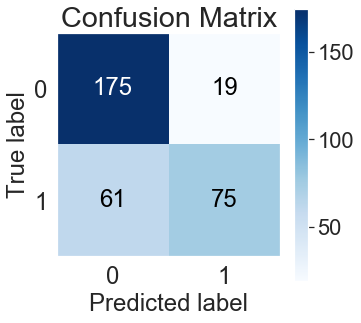

In [252]:
#Confusion matrix on the test set
skplt.metrics.plot_confusion_matrix(y2_test, predictions_test, labels=[0, 1], figsize=(5,5))
plt.show()

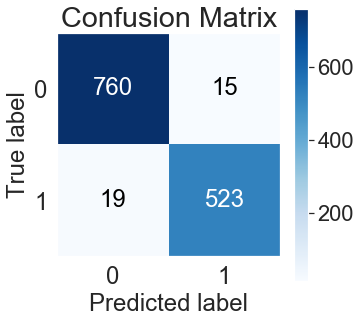

In [253]:
#Confusion matrix on the training set
skplt.metrics.plot_confusion_matrix(y2_train, predictions_train, labels=[0, 1], figsize=(5,5))
plt.show()

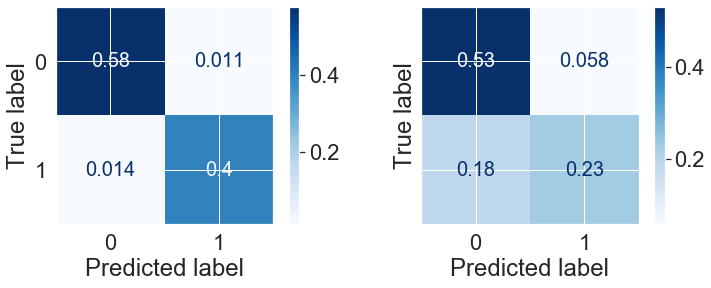

In [254]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
plot_confusion_matrix(lr2fit, X2_train, y2_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(lr2fit, X2_test, y2_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)        

plt.show()

### ROC curve on the training and test set

In [255]:
print('ROC_AUC score on train:' , (roc_auc_score(y2_train, lr2fit.predict_proba(X2_train)[:, 1])))
print('ROC_AUC score on test:' , (roc_auc_score(y2_test, lr2fit.predict_proba(X2_test)[:, 1])))

ROC_AUC score on train: 0.9972848470420188
ROC_AUC score on test: 0.8111544875682232


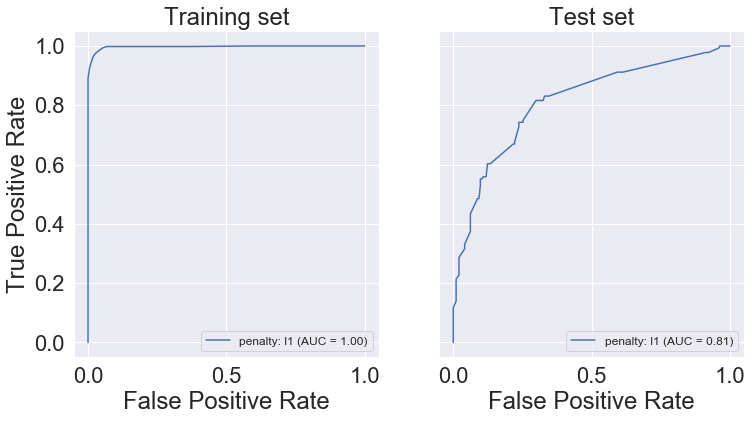

In [256]:
fig_roc, ax_roc = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
plot_roc_curve(lr2fit, X2_train, y2_train, ax=ax_roc[0], name='penalty: l1')
plot_roc_curve(lr2fit, X2_test, y2_test, ax=ax_roc[1], name='penalty: l1')
ax_roc[0].legend(loc='lower right', fontsize=12)
ax_roc[1].legend(loc='lower right', fontsize=12)
ax_roc[1].set_ylabel(None)
ax_roc[0].set_title('Training set')
ax_roc[1].set_title('Test set')
plt.show()

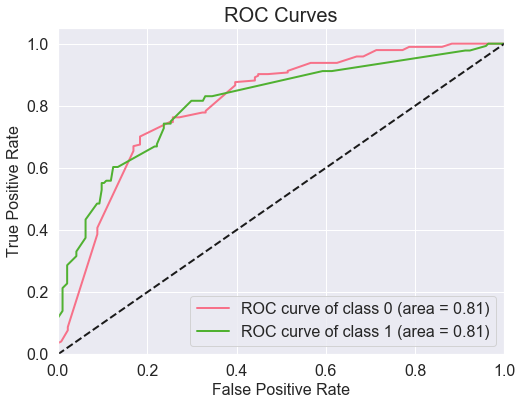

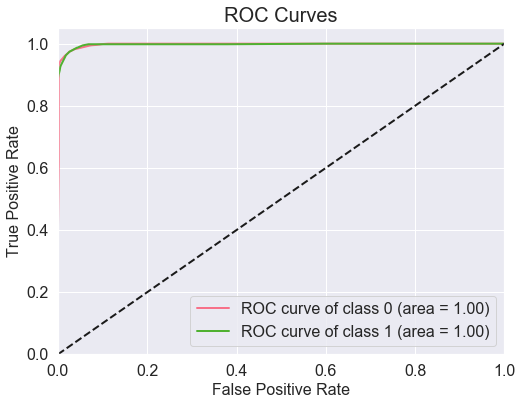

In [257]:
skplt.metrics.plot_roc(y2_test, lr2fit.predict_proba(X2_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

skplt.metrics.plot_roc(y2_train, lr2fit.predict_proba(X2_train), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

### Precision-recall curve on the training and test set

In [258]:
#Average precision score
print(average_precision_score(y2_train, lr2fit.predict_proba(X2_train)[ :, 1])) 
print(average_precision_score(y2_test, lr2fit.predict_proba(X2_test)[:, 1]))

0.9962160166715892
0.7596337106806059


In [259]:
#recall score
print(recall_score(y2_test, predictions_test))
print(recall_score(y2_train, predictions_train))

0.5514705882352942
0.9649446494464945


In [260]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(lr2fit.classes_)))

In [261]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

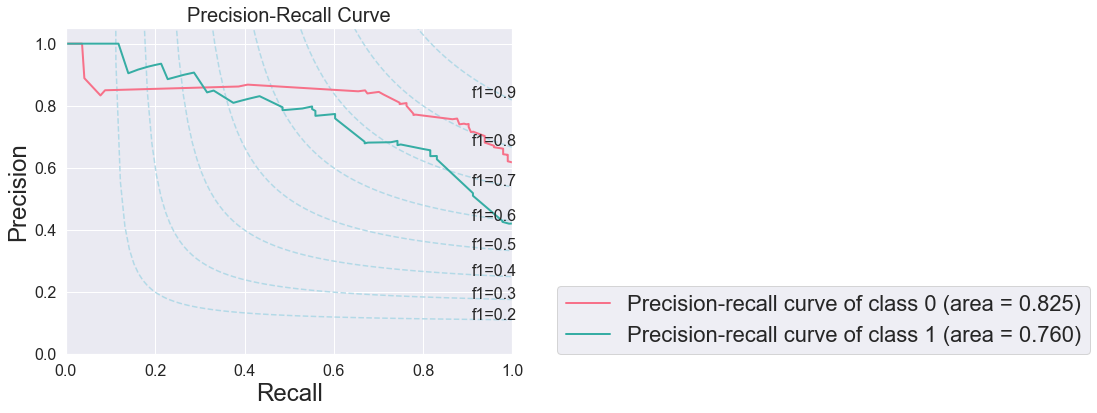

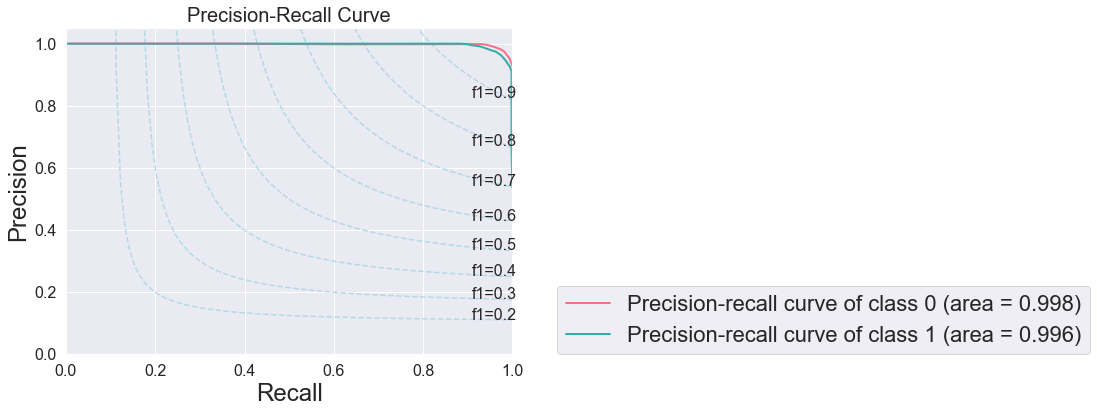

In [262]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y2_test, lr2fit.predict_proba(X2_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y2_train, lr2fit.predict_proba(X2_train),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

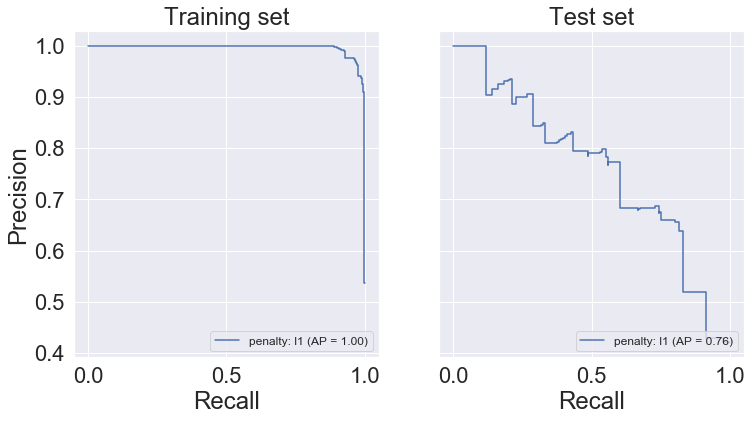

In [263]:
fig_pr, ax_pr = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
plot_precision_recall_curve(lr2fit, X2_train, y2_train, ax=ax_pr[0], name='penalty: l1')
plot_precision_recall_curve(lr2fit, X2_test, y2_test, ax=ax_pr[1], name='penalty: l1')
ax_pr[0].legend(loc='lower right', fontsize=12)
ax_pr[1].legend(loc='lower right', fontsize=12)
ax_pr[1].set_ylabel(None)
ax_pr[0].set_title('Training set')
ax_pr[1].set_title('Test set')
plt.show()

### Accuracy  and threshold

In [264]:
#Accuracy score on training set
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [280]:
#Accuracy score on train set
accuracy_score(y2_train, predictions_train)

0.9741837509491268

In [281]:
#Accuracy score on test set
accuracy_score(y2_test, predictions_test)

0.7575757575757576

Threshold: 0.01 false positives: 0.5878787878787879
Threshold: 0.02 false positives: 0.5666666666666667
Threshold: 0.03 false positives: 0.35454545454545455
Threshold: 0.04 false positives: 0.20303030303030303
Threshold: 0.05 false positives: 0.18484848484848485
Threshold: 0.06 false positives: 0.17575757575757575
Threshold: 0.07 false positives: 0.1484848484848485
Threshold: 0.08 false positives: 0.1393939393939394
Threshold: 0.09 false positives: 0.1393939393939394
Threshold: 0.1 false positives: 0.1303030303030303
Threshold: 0.11 false positives: 0.12727272727272726
Threshold: 0.12 false positives: 0.07878787878787878
Threshold: 0.13 false positives: 0.07878787878787878
Threshold: 0.14 false positives: 0.07575757575757576
Threshold: 0.15 false positives: 0.07272727272727272
Threshold: 0.16 false positives: 0.07272727272727272
Threshold: 0.17 false positives: 0.07272727272727272
Threshold: 0.18 false positives: 0.07272727272727272
Threshold: 0.19 false positives: 0.07272727272727272


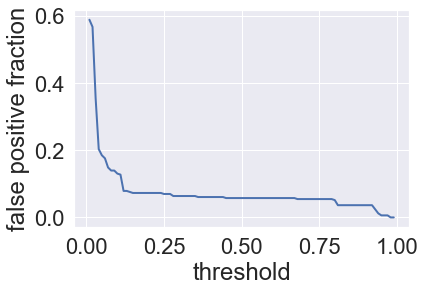

In [267]:
#false positive count as changing threshold for predicting label 1

false_positives = []
for thresh in np.arange(1, 100)/100.:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in lr2fit.predict_proba(X2_test)[:, 1]])
    fp = np.mean((y2_test == 0) & (labeled_1 == 1))
    false_positives.append((thresh, fp))
    print('Threshold:', thresh, 'false positives:', fp)
false_positives = np.array(false_positives)

plt.plot(*false_positives.T, lw=2)
plt.xlabel('threshold')
plt.ylabel('false positive fraction')
plt.show()

In [268]:
#Accuracy as changing your threshold for predicting label 1

Threshold: 0.01 Correct predictions: 0.4121212121212121
Threshold: 0.02 Correct predictions: 0.43333333333333335
Threshold: 0.03 Correct predictions: 0.6090909090909091
Threshold: 0.04 Correct predictions: 0.7272727272727273
Threshold: 0.05 Correct predictions: 0.7393939393939394
Threshold: 0.06 Correct predictions: 0.7484848484848485
Threshold: 0.07 Correct predictions: 0.7484848484848485
Threshold: 0.08 Correct predictions: 0.7545454545454545
Threshold: 0.09 Correct predictions: 0.7484848484848485
Threshold: 0.1 Correct predictions: 0.7363636363636363
Threshold: 0.11 Correct predictions: 0.7363636363636363
Threshold: 0.12 Correct predictions: 0.7575757575757576
Threshold: 0.13 Correct predictions: 0.7575757575757576
Threshold: 0.14 Correct predictions: 0.7606060606060606
Threshold: 0.15 Correct predictions: 0.7636363636363637
Threshold: 0.16 Correct predictions: 0.7636363636363637
Threshold: 0.17 Correct predictions: 0.7636363636363637
Threshold: 0.18 Correct predictions: 0.763636363

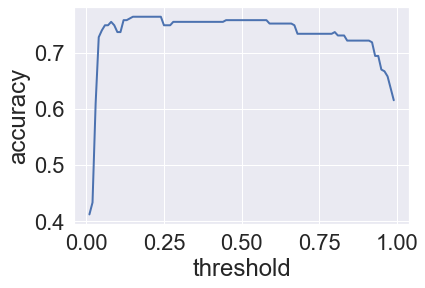

In [269]:
accuracies = []
for thresh in np.arange(1, 100)/100.:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in lr2fit.predict_proba(X2_test)[:, 1]])
    acc = np.mean(y2_test==labeled_1)
    accuracies.append((thresh, acc))
    print('Threshold:', thresh, 'Correct predictions:', acc)
accuracies = np.array(accuracies)

plt.plot(*accuracies.T, lw=2)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

In [270]:
# fraction of 1s predicted at threshold=0.5
lr2fit.predict(X2).mean()

0.02185792349726776

### Classification report for train and test set

In [272]:
print(classification_report(y2_train, predictions_train))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       775
           1       0.97      0.96      0.97       542

    accuracy                           0.97      1317
   macro avg       0.97      0.97      0.97      1317
weighted avg       0.97      0.97      0.97      1317



In [273]:
print(classification_report(y2_test, predictions_test))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       194
           1       0.80      0.55      0.65       136

    accuracy                           0.76       330
   macro avg       0.77      0.73      0.73       330
weighted avg       0.76      0.76      0.75       330



In [ ]:
#Conclusions are provided in the next topic

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

The object of this analysis is the data job market in Ireland, England and The Netherlands,  by using machine learning classification models with the intention to estimate factors that lead to high or low salary.

 The study starts with Indeed’s page web scraping, which consists in extracting the information about job posts from the website page by page.  For this task, 4 features were initially considered: company, salary, and job title location,  and during the analysis,  other 3 features were added.

Since the data was obtained from web scrapping, the main model limitation is the diferences how companies classify their positions: for example, some companies do not use seniority, at least not in their job title, so it makes more complex to define in this model how experience plays a part in the target.

The scores presented will vary from 0 to 1. The higher, the better the model perfomance. The baseline, which provide the point of comparison for the model performance evaluation, has a value of 0.5883

There were 2 different major analysis using the following 3 models: Logistic Regression, Decision Tree classifier and K-Nearest Neighbor, all being cross-valdated with Gridsearch method, necessary in order to increase the models credibility . 

The first analysis have the ‘location’ variable as the salary predictor and all models have the score of 0.6424, which is not much higher from baseline. Hence, is possible to conclude that this variable on itself, it is not enough for an accurate high x low salary prediction 

On the second analysis, it was used the variables: ‘location’ and ‘jobtitle’ combined with the new variables: ‘seniority’ (describing the job seniority) ’keyword’ (featuring the most used keywords in the job titles) and ‘high_low’ (used to point wether a salary was higher or lower than the average.
After running the mentioned 3 models, the best score was 0.7304 obtained  with the Logistic Regression.

After selecting this model, further evaluation were made on its features: AUC, accuracy, precision and recall with visual representation as well.

The accuracy score shows the proportion of correct guesses in the model. The score obtained is 0.7575The ‘precision’ measures how many times the true label was positive out of all the times the classifier predicted a positive label. The ‘recall’ measures how many times the predicted label was positive out of the times the true label was positive.

An effective method to analyze these numbers is with the ROC curve graph, where the area under the ROC curve is used to measure how well the model performs. As mentioned before, the closer to 1, the better is the models performance.

 Even though the area under the ROC curve is directly related to the accuracy, the AUC-ROC is preferred over the accuracy because it is automatically adjusted to the baseline and presents a more clear picture of how the classifier performs at different threshold choices. The Threshold represents, in a binary classification, the probability that the prediction is true. It represents the tradeoff between false positives and false negatives. As the threshold decreases for the positive class, the recall automatically increase

Accuracy for models is indeed very important,  so is recall. A balance between precision and recall would be ideal, but this statement is not necessarily true for all scenarios. For the given analysis, the tolerance for false positives is low, since it is preferable for the business reputation to set the client’s salary expectation for lower than reality rather than the other way around. Therefore, for the model’s best performance, the recall score should be prioritized over accuracy, and consequently, threshold will be smaller. 


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.